In [1]:
%matplotlib inline

import jax.numpy as jnp
from jax import value_and_grad
from jax import random
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as snb


from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


# we want to use 64 bit floating precision
import jax
import sys
import os
sys.path.append(os.path.abspath('..'))
from functions import *
jax.config.update("jax_enable_x64", True)

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.25)



# 02477 Bayesian Machine Learning: Exercise 5

The purpose of this exercise is to
- learn how to sample from a multivariate Gaussian distribution
- become familiar with covariance functions, especially stationary covariance functions such as the squared exponential and Matérn family and to understand their properties and hyperparameters
- become familiar with Gaussian processes and learn to use them as prior distribution for latent functions in regression settings


**Content**

- Part 1: Sampling from a multivariate Gaussian distribution
- Part 2: Stationary covariance functions
- Part 3: Non-linear regression using Gaussian processes
- Part 4: Hyperparameter optimization using the marginal likelihood
- Part 5: Analysing the bike sharing data set


**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

# Introduction

When we worked with parametric models such as linear regression and logistic regression, we assigned prior distributions on the weights $\mathbf{w}$ of the models. In contrast, we can think of Gaussian processes as prior distributions directly on the function space

$$\begin{align*}
f(\mathbf{x}) \sim \mathcal{GP}\left(m(\mathbf{x}) \, , \, k\left(\mathbf{x}, \mathbf{x}'\right)\right)
\end{align*}$$

where $f: \mathbb{R}^D \rightarrow \mathbb{R}$ and $\mathbf{m}(\mathbf{x}) = \mathbb{E}\left[f(\mathbf{x})\right]$, and $\mathbf{k}(\mathbf{x}, \mathbf{x}') = \mathbb{E}\left[\left(f(\mathbf{x})-m(\mathbf{x})\right)\left(f(\mathbf{x'})-m(\mathbf{x'})\right)\right]$ are the **mean function** and **covariance function**, respectively, for $\mathbf{x}, \mathbf{x}' \in \mathbb{R}$.


A Gaussian process is completely specified by its mean and covariance function. Most often we take the mean function to be zero, $m(\mathbf{x}) = 0$, because we don't have any prior information on the mean function:

$$\begin{align*}
f(\mathbf{x}) \sim \mathcal{GP}\left(0 \, , \, k\left(\mathbf{x}, \mathbf{x}'\right)\right), \tag{1}
\end{align*}$$

The **covariance function** (or kernel function) $k(\mathbf{x}, \mathbf{x}')$ thus completely determines the a priori behavior of the latent function $f$. Specifically, the covariance function determines the covariance of the latent function $f$ when evaluated at two different inputs, i.e.

$$\begin{align*}
\text{cov}[f(\mathbf{x}), f(\mathbf{x}')] = k(\mathbf{x}, \mathbf{x}'). \tag{2}
\end{align*}$$


The **squared exponential** covariance function is given by

\begin{align*} 
    k_{\text{SE}}(\mathbf{x}_n, \mathbf{x}_m) = \kappa^2 \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_m\|^2_ 2}{2\ell^2}\right), \tag{3}
\end{align*}

where $\kappa > 0$ and $\ell > 0$ are hyperparameters of the kernel. This specific covariance function is perhaps the most common covariance function used in statistics and machine learning. It is also known as the radial basis function kernel, the gaussian kernel, or the exponentiated quadratic kernel. We will also study two covariance functions from the Matérn family:

$$\begin{align*}
k_{\text{Matern12}}(\mathbf{x}_n, \mathbf{x}_m) &= \kappa^2 \exp\left(-\frac{||\mathbf{x}_n- \mathbf{x}_m||}{\ell}\right)\\
k_{\text{Matern32}}(\mathbf{x}_n, \mathbf{x}_m) &= \kappa^2 \left(1 + \frac{\sqrt{3}||\mathbf{x}_n - \mathbf{x}_m||}{\ell}\right)\exp\left(-\frac{\sqrt{3}||\mathbf{x}_n- \mathbf{x}_m||}{\ell}\right).
\end{align*}
$$




# Part 1:  Sampling from a multivariate Gaussian distribution


To become familiar with covariance functions and understand its properties, we will generate and visualize samples from Gaussian process distributions. Therefore, our first order of business will be to implement a function for generating samples from a Gaussian process prior.


Let $\mathbf{X} = \left\lbrace \mathbf{x}_n \right\rbrace_{n=1}^N $ be a set of points in the real line, i.e. $\mathbf{x}_n \in \mathbb{R}^D$, and let $f: \mathbb{R}^D \rightarrow \mathbb{R}$ be a function. Let $f_n \equiv f(x_n) \in \mathbb{R}$ be the value of the function $f$ evaluated at $x_n \in \mathbb{R}$. Furthermore, let $\mathbf{f} \equiv \left[f_1, f_2, \dots, f_N\right] \in \mathbb{R}^{N \times 1}$ be the vector of function values for each of the points in $\mathbf{X}$, then the Gaussian process prior for $\mathbf{f}$ becomes

$$\begin{align*}
\mathbf{f} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{K}\right), \tag{4}
\end{align*}
$$

where $\mathbf{K} \in \mathbb{R}^{N \times N}$ is the kernel matrix satisfying $\mathbf{K}_{nm} = k(\mathbf{x}_n ,\mathbf{x}_m)$, where $\mathbf{x}_n$ refers to the $n$'th input point, i.e. the $i$'th entry of $\mathbf{X}$.

The **Cholesky decomposition** is sometimes refered to as *matrix square root* and it is really handy matrix decomposition for sampling from a multivariate Gaussian distribution. The Cholesky decomposition of the kernel matrix is given by $\mathbf{K} = \mathbf{L}\mathbf{L}^T$, where $\mathbf{L} \in \mathbb{R}^{N \times N}$ is a lower triangular matrix.

The idea is to generate samples from standardized Gaussian distributions, and then transform those samples into the desired distribution. Let $\mathbf{z} \in \mathbb{R}^{N \times 1}$ be a sample from a standardized multivariate Gaussian distribution, i.e. $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_n)$, where $\mathbf{I}_n$ is the identity matrix of size $N \times N$.

### Why to use Cholesky Decomposition? 
- Sampling directly from the multivariate Gaussian distribution $\mathcal{N}(\mathbf{m}, \mathbf{K})$ is tricky, because the covariance matrix $\mathbf{K}$ introduces dependencies between the different dimensions of the Gaussian distribution. On the countrary the covariance matrix of the standardized Gaussian distribution is the identity matrix $\mathbf{I}_n$, which means that the dimensions are independent.

- We then reshape it into something more useful. The Choelsky decomposition $\mathbf{K} = \mathbf{L}\mathbf{L}^T$ provides a "square root" of the covariance matrix. If we multiply $\mathbf{z}$ by $\mathbf{L}$, we transform the independent stanadardized Gaussian samples $\mathbf{z}$ into correlated samples $\mathbf{Lz}$, with covariance matrix $\mathbf{K}$.

- A standard gaussian $\mathcal{N}(\mathbf{0}, \mathbf{I}_n)$ looks like a spherical clound of points. 
    - Multiplying by $\mathbf{L}$ will rotate and stretch the cloud into ellipsoidal shape descried by the covariance matrix $\mathbf{K}$.
    - Adding the mean $\mathbf{m}$ will shift the cloud to the desired location.

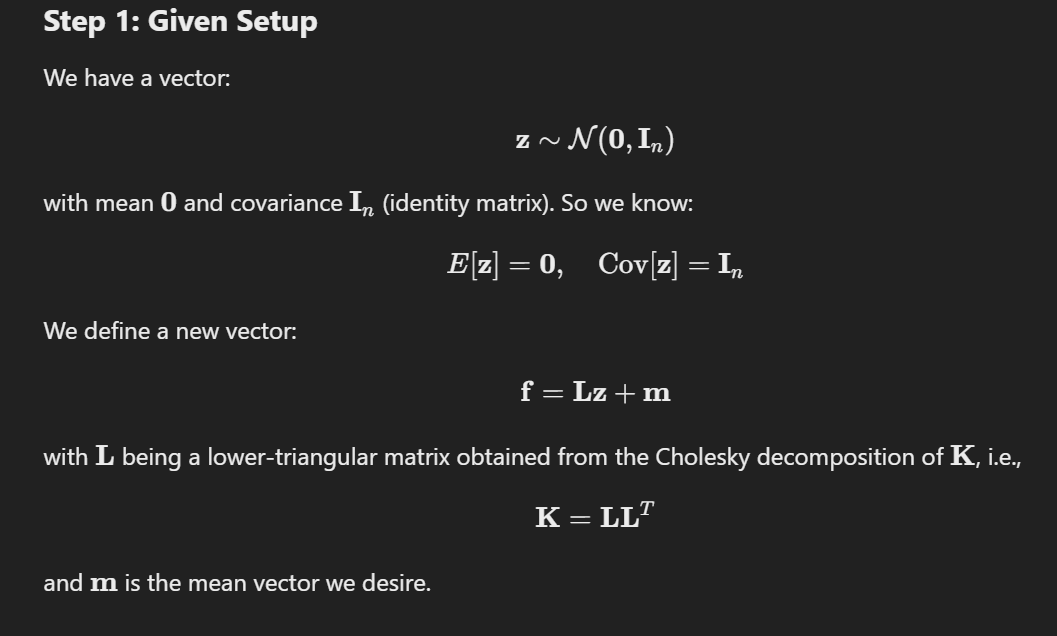



 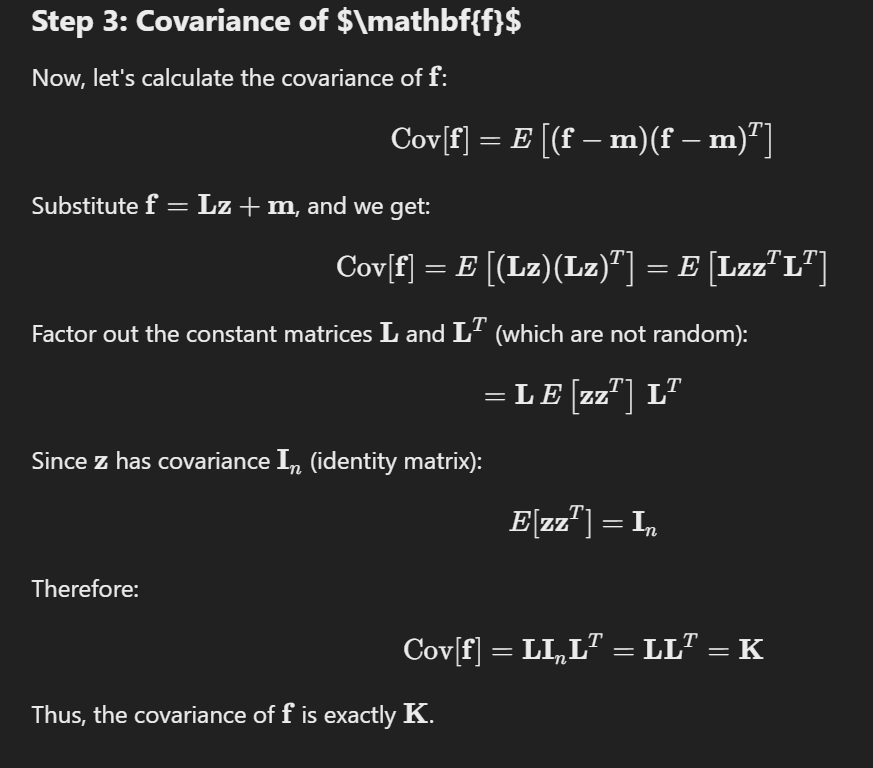

 

**Task 1.1**: Show that if $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_n)$ and $\mathbf{m} \in \mathbb{R}^{N}$, then $\mathbf{f} = \mathbf{L}\mathbf{z} + \mathbf{m} \sim \mathcal{N}(\mathbf{m}, \mathbf{K})$. 

All real-valued symmetric and positive definite matrices have a unique Cholesky decomposition. However, due to finite precision in computers, the covariance matrices used in Gaussian processes can sometimes have negative eigenvalues in practice and hence fail to be positive definite. A common trick is to add a small positive number $\epsilon > 0$ to the diagonal of the covariance matrix, which will increase the eigenvalues of the covariance matrix $\mathbf{K}$ and hence change the sign of a potential small negative eigenvalue. Hence, in practice we construct the covariance matrix as:

$$
\begin{align*}
\mathbf{K}_{nm}  = k(\mathbf{x}_n, \mathbf{x}_m) + \epsilon \delta(\mathbf{x}_n-\mathbf{x}_m),
\end{align*}
$$

where $\delta(\cdot)$ is **Kronenecker's delta function** defined by 

$$\begin{align*}
\delta(\mathbf{x}_n-\mathbf{x}_m) = \begin{cases} 1 & \text{if}\quad \mathbf{x}_n=\mathbf{x}_m \\ 0 & \text{otherwise} \end{cases}
\end{align*}
$$

We often say we add **jitter** to the covariance matrix. $\epsilon$ should be as small as positive to avoid affecting the results, e.g. a typical number is $\epsilon \approx 10^{-8}$. If $\epsilon$ needs to be significantly bigger, then it is likely that there are some other implementation issues, which should be addressed.

**Task 1.2**: **(optional)** Can you prove that adding jitter increases the eigenvalues of the resulting matrix?




**Task 1.3**: Complete the implementation of the function `generate_samples` below for sampling from a multivariate Gaussian using the method described above. 

*Hints*:
- *The function jnp.linalg.cholesky is handy for computing the Cholesky decomposition of a matrix.*
- *You need to add the jitter before computing the Cholesky decomposition.*
- *The argument `key` is for controlling the random number generator in JaX. Sampling is an inherently stochastic procedure, but the explicit use of such keys allows us to build reproducible code in the sense that if we provide the same key, we get the same output.*

In [2]:
def generate_samples(key, m, K, num_samples, jitter=0):
    """
    Generate samples from a multivariate Gaussian distribution N(m, K)
    - where m is the mean vector of shape (N,)
    - K is the covariance matrix of shape (N, N)

    
    Uses the Cholesky decomposition method to transform standard normal samples:
    
    1. If z ~ N(0, I) (standard normal), and if K = L L^T (Cholesky decomposition), then:
       f = m + Lz ~ N(m, K)
    
    2. Adding jitter to the diagonal elements for numerical stability:
       K_jitter = K + jitter * I
       where I is the identity matrix of the same shape as K.

    3. Computing Cholesky decomposition:
       L = cholesky(K_jitter)
    
    4. Generating samples:
       f = m + Lz
    
    Arguments:
        key          -- JAX random key for controlling the random number generator.
        m            -- Mean vector (shape (N,)).
        K            -- Covariance matrix (shape NxN).
        num_samples  -- Number of samples to generate (positive integer).
        jitter       -- Amount of jitter to add to the diagonal for numerical stability.
    
    Returns:
        f_samples    -- Matrix containing the samples (shape N x num_samples).
    """
    # Get dimension from covariance matrix
    N = len(K)

    # Generate standard normal samples z ~ N(0, I)
    zs = random.normal(key, shape=(N, num_samples))
    print(f"The shape of z's: {zs.shape}")

    # Add jitter to diagonal elements for numerical stability
    K_jitter = K + jnp.eye(N) * jitter
    

    # Compute the Cholesky decomposition: K = LL^T
    L = jnp.linalg.cholesky(K_jitter)


################ CODE BELOW IS FOR DEBUGGING PURPOSES ################
    print(f"Shape of the mean, mu {m.shape}")
    # printing the reshaped mean vector after broadcasting
    m_reshaped = m.reshape(-1, 1)                           # shape (N, 1)
    print(f"Shape of mu after broadcasting {m_reshaped.shape}")
    print(f"Shape of L: {L.shape}")
################ CODE ABOVE IS FOR DEBUGGING PURPOSES ################

    # transform the samples: f = m + L*z
    f_samples = m_reshaped + L @ zs

    print(f"Shape of f_samples {f_samples.shape}")
    # Verify output dimensions
    assert f_samples.shape == (N, num_samples), f"Incorrect sample shape: expected ({N}, {num_samples}), got {f_samples.shape}"
    
    return f_samples


# sanity check of implementation
key = random.PRNGKey(1)
num_samples = 10000
m = jnp.array([jnp.pi, jnp.sqrt(2)])
V = jnp.array([[0.123, -0.05], [-0.05, 0.123]])
f_samples = generate_samples(key, m, V, num_samples)
assert jnp.linalg.norm(jnp.mean(f_samples, 1)- m) < 1e-2, "The mean of f_samples appears wrong. Please check your code"
assert jnp.linalg.norm(jnp.cov(f_samples) - V) < 1e-2, "The covariance of f_samples appears wrong. Please check your code"




The shape of z's: (2, 10000)
Shape of the mean, mu (2,)
Shape of mu after broadcasting (2, 1)
Shape of L: (2, 2)
Shape of f_samples (2, 10000)


In [3]:
# plot the samples  
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(f_samples[0, :], f_samples[1, :], 'o', alpha=0.5)
# plot the mean and variance as well 
ax.plot(m[0], m[1], 'ro', markersize=10, label='mean')
ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_title('Samples from the GP')
ax.legend()
plt.show()


We will use this function in the next section to generate samples from a Gaussian process.

# Part 2:  Stationary covariance functions

Next, we will dive deeper into the covariance functions and their properties. We will focus on so-called **stationary** covariance functions.

The squared exponential kernel is an example of a **stationary** kernel, which means that the covariance function only depends on the difference between two points, i.e. $\tau = \mathbf{x}_n - \mathbf{x}_m$ for two points in the input space $\mathbf{x}_n, \mathbf{x}_m \in \mathbb{R}^D$:

$$\begin{align*}
    k_{\text{SE}}(\mathbf{x}_n, \mathbf{x}_m) = \kappa^2 \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_m\|^2_ 2}{2\ell^2}\right) = \kappa^2 \exp\left(-\frac{\|\tau\|^2_ 2}{2\ell^2}\right) = k(\tau).
\end{align*}$$

 Furthermore, if the covariance function only depends on the distance between any two inputs, i.e. $||\tau||_2 = ||\mathbf{x}_n - \mathbf{x}_m||_2$, then the covariance function is also said to be **isotropic** (isotropic is a fancy word for rotation invariance). For the squared exponential kernel we can write:

$$\begin{align*}
    k_{\text{SE}}(\mathbf{x}_n, \mathbf{x}_m) = k(||\tau||) =  \kappa^2 \exp\left(-\frac{\|\tau\|^2_ 2}{2\ell^2}\right), \tag{5}
\end{align*}$$

which shows that the squared exponential kernel is both **stationary** and **isotropic** since it can be written as a function $\|\tau\|$. Note that we in the above overload and abuse the notation of $k$ a bit.

Consider the following four covariance functions: the linear kernel, the Matern $\frac12$ kernel, the Matern $\frac32$ kernel and the so-called automatic relevance determination (ARD) kernel given by

$$\begin{align*}
k_{\text{Linear}}(\mathbf{x}_n, \mathbf{x}_m) &= \alpha^{-1} \mathbf{x}^T_m \mathbf{x}_n\\
k_{\text{Matern12}}(\mathbf{x}_n, \mathbf{x}_m) &= \kappa^2 \exp\left(-\frac{||\mathbf{x}_n- \mathbf{x}_m||}{\ell}\right)\\
k_{\text{Matern32}}(\mathbf{x}_n, \mathbf{x}_m) &= \kappa^2 \left(1 + \frac{\sqrt{3}||\mathbf{x}_n - \mathbf{x}_m||}{\ell}\right)\exp\left(-\frac{\sqrt{3}||\mathbf{x}_n- \mathbf{x}_m||}{\ell}\right)\\
k_{\text{ARD}}(\mathbf{x}_n, \mathbf{x}_m) &= \kappa^2 \exp\left(-\frac12 \sum_{i=1}^D \frac{(\mathbf{x}_{n,i} -\mathbf{x}_{m,i})^2}{\ell_i}\right)  = \kappa^2 \exp\left(-\frac12 (\mathbf{x}_n- \mathbf{x}_m)^T \mathbf{L} \left(\mathbf{x}_n- \mathbf{x}_m)\right)\right),  
\end{align*}$$

where $\mathbf{L} \in \mathbf{R}^{D \times D}$ is a diagonal matrix $\mathbf{L} = \text{diag}(\ell^2_1, \ell^2_2, \dots, \ell^2_D)$. The ARD-kernel can be seen as a generalization of the squared exponential kernel, where each dimension of $\mathbf{x}$ has a separate characteristic lengthscale. 

**Task 2.1**: Which of the four kernels above are stationary kernels and which isotropic kernels?



Next, we will implement the squared exponential kernel, the Matérn $\frac{1}{2}$, and the Matérn $\frac{3}{2}$ kernel. The and the cell below provide an implementation of these kernels expressed as a function norm of the distance of the inputs, $||\tau|| = ||\mathbf{x}_n - \mathbf{x}_m||$, e.g. 

$$\begin{align*}
k_{\text{SE}}(||\tau||) = \kappa^2 \exp\left(-\frac{\|\tau\|^2_ 2}{2\ell^2}\right).
\end{align*}$$

In [4]:
# in the code below tau represents the distance between to input points, i.e. tau = ||x_n - x_m||.
def squared_exponential(tau, kappa, lengthscale):
    return kappa**2*jnp.exp(-0.5*tau**2/lengthscale**2)

def matern12(tau, kappa, lengthscale):
    return kappa**2*jnp.exp(-tau/lengthscale)

def matern32(tau, kappa, lengthscale):
    return kappa**2*(1 + jnp.sqrt(3)*tau/lengthscale)*jnp.exp(-jnp.sqrt(3)*tau/lengthscale)


Below you are given a vector $\mathbf{X} \in \mathbb{R}^{N \times 1}$ of $N = 1000$ points on the real line. The points are sorted and equidistantly distributed in the interval $\left[-6, 6\right]$.

In order to construct the kernel matrices, all we need to do now is to implement some code for evaluating all the pairwise distances, i.e. $||\mathbf{x}_n - \mathbf{x}_m||$ for all pairs of input points, and then feed these distances to the covariance function above along with values for the hyperparameters. This "two-step" implementation makes it easy to switch between different covariance functions. 

**Task 2.2**: Complete the implementation of the class *StationaryIsotropicKernel* below.

*Hints: The function `construct_kernel` contain three steps:*

1) *compute all the pairwise distances between `X1` and `X2`,*

2) *feed these distance to the covariance function `kernel_fun`,*

3) *add jitter if needed*

- *You can either compute the pairwise distances using for-loops or using a vectorized solution. Using for-loops is a bit slower, but might be easier to understand and debug*

In [5]:
class StationaryIsotropicKernel(object):

    def __init__(self, kernel_fun, kappa=1., lengthscale=1.0):
        """
        Initialize the Stationary Isotropic Kernel with a given kernel function.
        
        The argument kernel_fun must be a function of three arguments:
        
        kernel_fun(||tau||, kappa, lengthscale), for example:
        squared_exponential = lambda tau, kappa, lengthscale: kappa**2 * np.exp(-0.5 * tau**2 / lengthscale**2)
        
        The kernel function models the covariance between points based on their distance,
        ensuring that closer points have higher similarity.
        
        Arguments:
            kernel_fun  -- Function defining the kernel.
            kappa       -- Magnitude (positive scalar, default 1.0), representing overall variance.
            lengthscale -- Characteristic lengthscale (positive scalar, default 1.0), controlling smoothness.
        """
        self.kernel_fun = kernel_fun
        self.kappa = kappa
        self.lengthscale = lengthscale

    def contruct_kernel(self, X1, X2, kappa=None, lengthscale=None, jitter=1e-8):
        """
        Compute and return the NxM kernel matrix between the two sets of input X1 (shape NxD) and X2 (MxD) using 
        the stationary and isotropic covariance function specified by self.kernel_fun.
    
        The kernel function is applied to the pairwise distances between input points:
        
        K[i, j] = kernel_fun(||X1_i - X2_j||, kappa, lengthscale)
        
        where:
        - ||X1_i - X2_j|| represents the Euclidean distance between two points.
        - kappa controls the overall variance.
        - lengthscale determines how quickly correlations decay with distance.
    
        Arguments:
            X1          -- NxD matrix of input points.
            X2          -- MxD matrix of input points.
            kappa       -- Magnitude (positive scalar, default is self.kappa).
            lengthscale -- Characteristic lengthscale (positive scalar, default is self.lengthscale).
            jitter      -- Non-negative scalar to stabilize computations (default 1e-8), used to ensure numerical stability.
        
        Returns:
            K           -- NxM kernel matrix representing covariances between input points.
        """
        # Extract dimensions 
        N, M = X1.shape[0], X2.shape[0]

        # Prepare hyperparameters
        kappa = self.kappa if kappa is None else kappa
        lengthscale = self.lengthscale if lengthscale is None else lengthscale

        # Compute pairwise distances (vectorized approach for efficiency)
        X1_expanded = X1[:, None, :]  # Shape: (N, 1, D)
        X2_expanded = X2[None, :, :]  # Shape: (1, M, D)
        pairwise_diff = X1_expanded - X2_expanded  # Shape: (N, M, D)
        pairwise_dist = jnp.linalg.norm(pairwise_diff, axis=2)  # Shape: (N, M)

        # Apply kernel function
        K = self.kernel_fun(pairwise_dist, kappa, lengthscale)

        # Add jitter to diagonal if X1 and X2 are the same set (stabilizes Cholesky decomposition)
        if jnp.array_equal(X1, X2):
            K = K + jnp.eye(N) * jitter

        # Alternative implementation 
        ##### # STEP 1: Compute all pairwise distances and apply kernel function
        ##### K = jnp.zeros((N, M))
        ##### for i in range(N):
        #####     for j in range(M):
        #####         # Compute pairwise distance using Euclidean norm
        #####         diff = X1[i] - X2[j]
        #####         distance = jnp.linalg.norm(diff)
        #####         # Apply kernel function to compute covariance
        #####         k_value = self.kernel_fun(distance, kappa, lengthscale)
        #####         # Update kernel matrix entry
        #####         K = K.at[i, j].set(k_value)
        ##### 
        ##### # STEP 2: Add jitter if X1 and X2 are identical (for numerical stability)
        ##### if jnp.array_equal(X1, X2):
        #####     identity = jnp.eye(N)
        #####     jitter_matrix = identity * jitter
        #####     K = K + jitter_matrix

        assert K.shape == (N, M), f"The shape of K appears wrong. Expected shape ({N}, {M}), but got {K.shape}."
        return K


# Create an Nx1 vector of equidistant points in the range [-6, 6]
N = 100
X = jnp.linspace(-6, 6, N)[:, None]

# Hyperparameters defining the kernel behavior
kappa = 1.  # Controls the variance (amplitude of the function)
scale = 1.  # Lengthscale, determines smoothness of the function

# Number of function samples to be plotted
num_samples = 10

# Specify random seed for reproducibility
seed = 1
key = random.PRNGKey(1)

# Instantiate kernel object and construct kernel matrix
kernel = StationaryIsotropicKernel(squared_exponential, kappa, scale)
K = kernel.contruct_kernel(X, X)

# Plot kernel matrix and function samples
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Kernel matrix visualization (shows covariance between points)
m = jnp.zeros(len(X))
im = ax[0].pcolormesh(X.flatten(), X.flatten(), K, shading='auto')
ax[0].set(xlabel='Input x', ylabel="Input x'", 
           title=f"Kernel function k(x, x') for kappa = {kappa:2.1f} and ell = {scale:2.1f}")
ax[0].grid(False)
ax[0].set_aspect('equal')
add_colorbar(im, fig, ax[0])

# Generate and plot samples from the Gaussian process
# f_samples ~ N(0, K), drawn from the multivariate normal distribution
f_samples = generate_samples(key, m, K, num_samples=num_samples, jitter=1e-8)
ax[1].plot(X, f_samples, alpha=0.75, linewidth=3)
ax[1].grid(True)
ax[1].set(xlabel='x', ylabel='f(x)', title=f'Samples from the Gaussian process with {kernel.kernel_fun.__name__} kernel')


The shape of z's: (100, 10)
Shape of the mean, mu (100,)
Shape of mu after broadcasting (100, 1)
Shape of L: (100, 100)
Shape of f_samples (100, 10)


[Text(0.5, 0, 'x'),
 Text(0, 0.5, 'f(x)'),
 Text(0.5, 1.0, 'Samples from the Gaussian process with squared_exponential kernel')]

## Interpreting the axes and right plot of the functions 
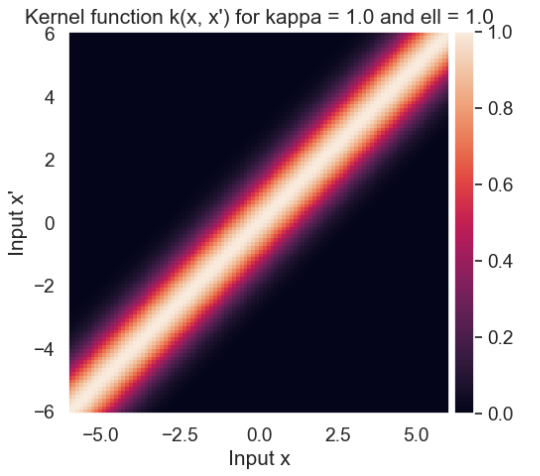
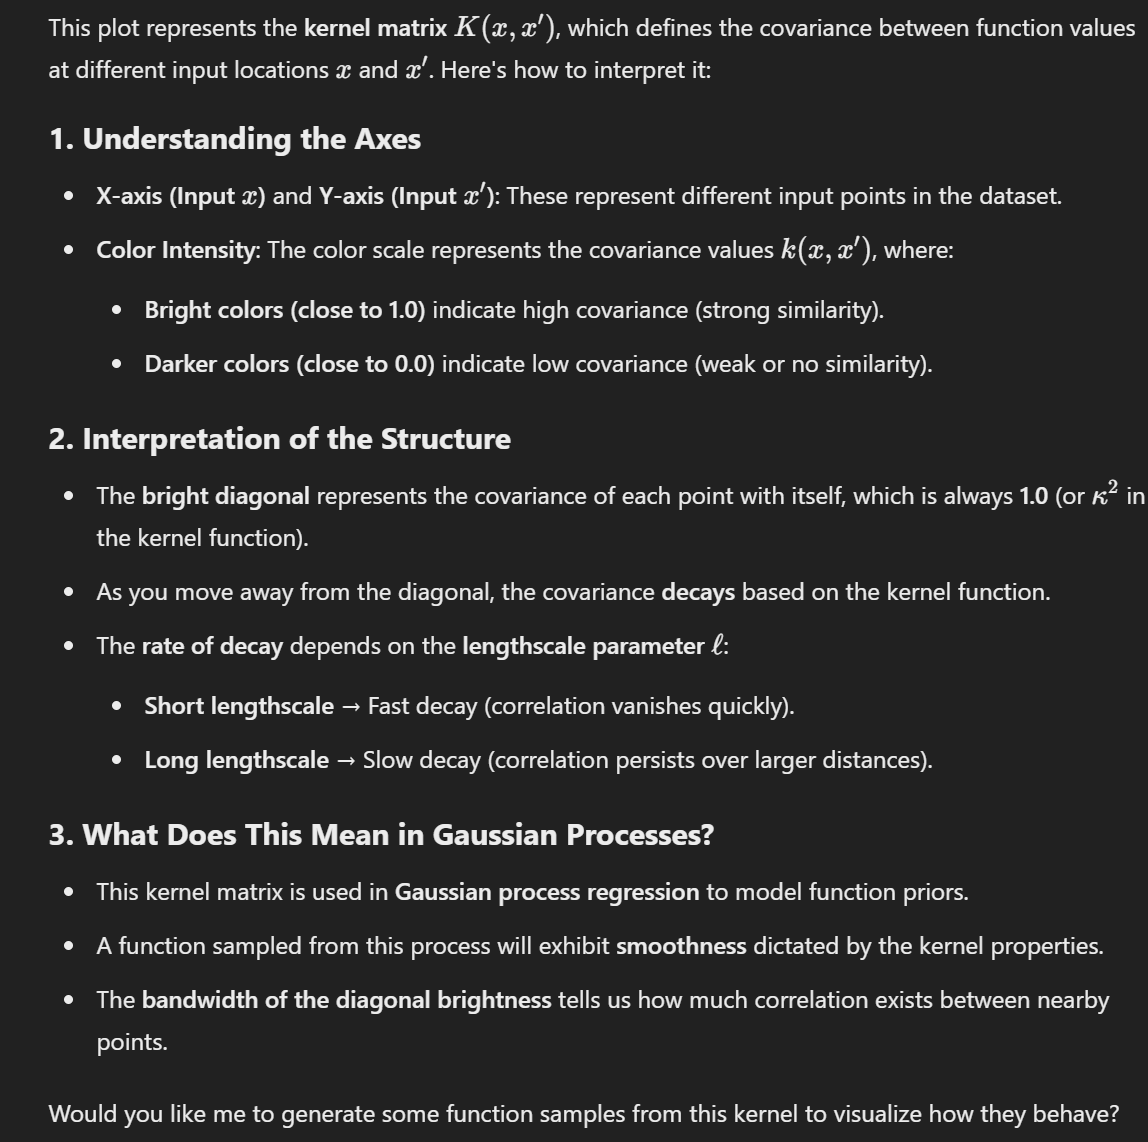
_____
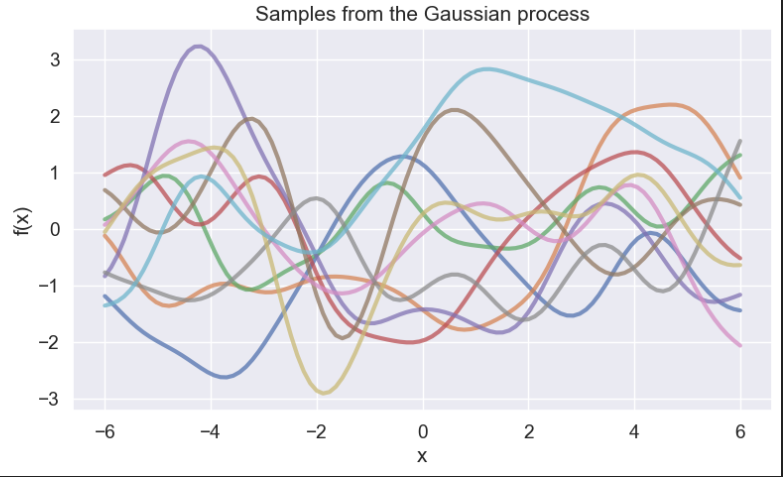

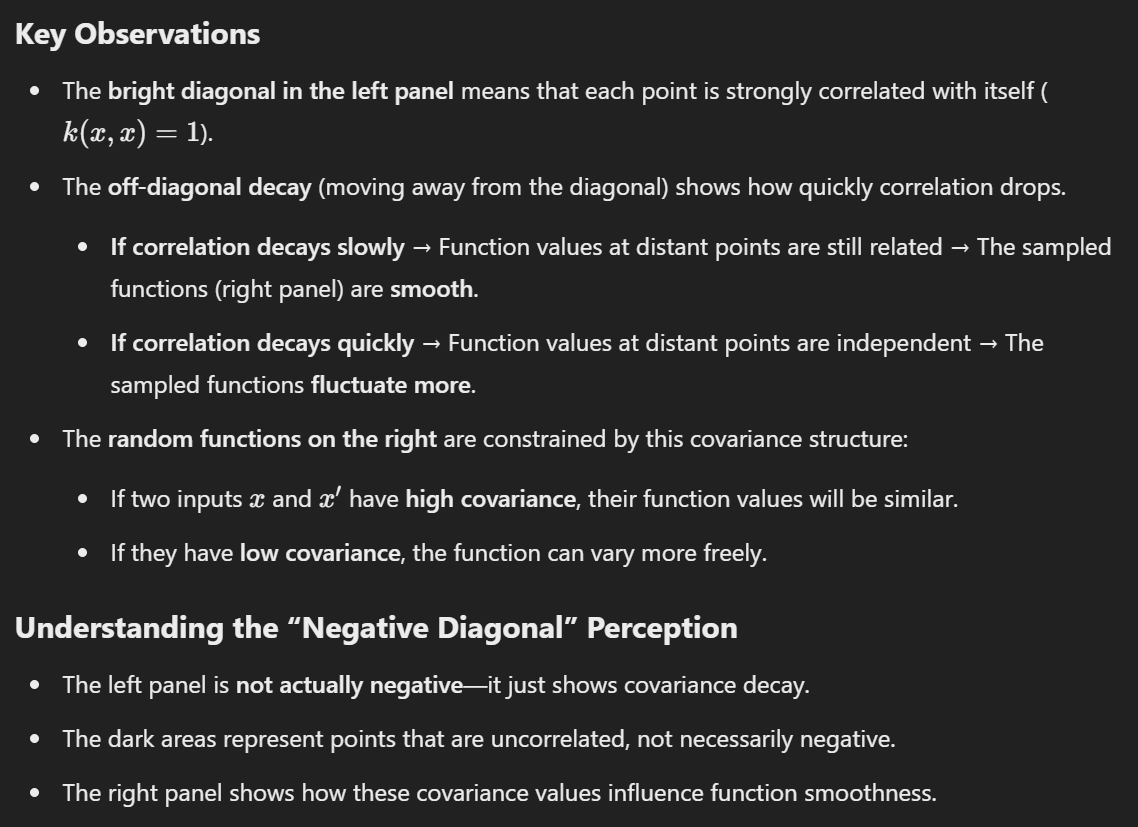

If your code is correct, the cell above you produce a plot of the covariance matrix as well as a plotting a number of samples form the corresponding Gaussian process.

**Task 2.3**: Inspect the plots above. Change the parameters $\kappa, \ell$ and explain how they affect the structure of the kernel (left panel)  [**Discussion question**]

**Task 2.4**: Inspect the plots above. Change the parameters $\kappa, \ell$ and explain how they affect the prior samples (right panel) [**Discussion question**]

#### Inspecting $\ell$

##### $\ell = 5$

- Settings $\ell = 5$ and $\kappa = 1$ gives a high correlation in the covariance matrix. We observe that the entire matrix is very bright, which means that the function values are highly correlated. The samples from the Gaussian process are very smooth and have a long range of correlation.
- The correlation decays very slowly as we move away from the diagonal in the covariance matrix. This means that the function values are highly correlated even for points that are far apart. The samples from the Gaussian process are very smooth and have a long range of correlation.

##### $\ell = 0.5$

- Setting $\ell = 0.5$ and $\kappa = 1$ gives a low correlation in the covariance matrix. We observe that the entire matrix is very dark (except on the diagonal), which means that the function values are not very correlated. The samples from the Gaussian process are very wiggly and have a short range of correlation
- Faster decay, meaning function values become uncorrelated quickly, leading to rougher functions. 

#### Inspecting $\kappa$

##### $\kappa = 5$
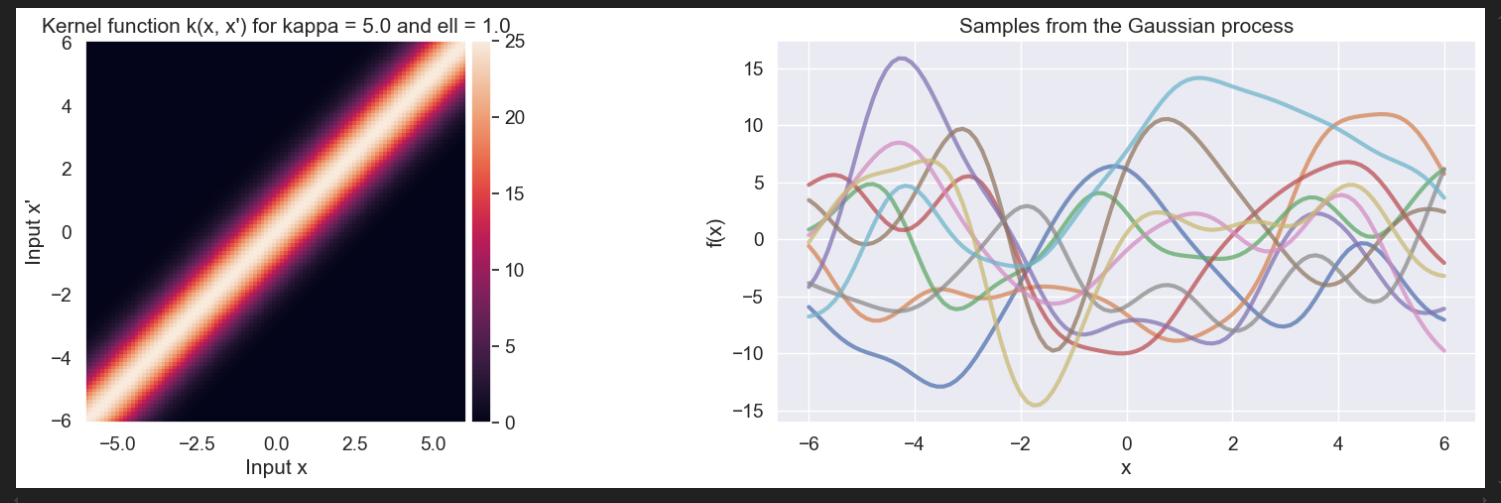
- Setting $\kappa = 5$ and $\ell = 1$ scales the covariance matrix. The amplitude of the function values is higher.
- The variance values are higher, leading to larger variations in the function values of the samples.

##### $\kappa = 0.5$
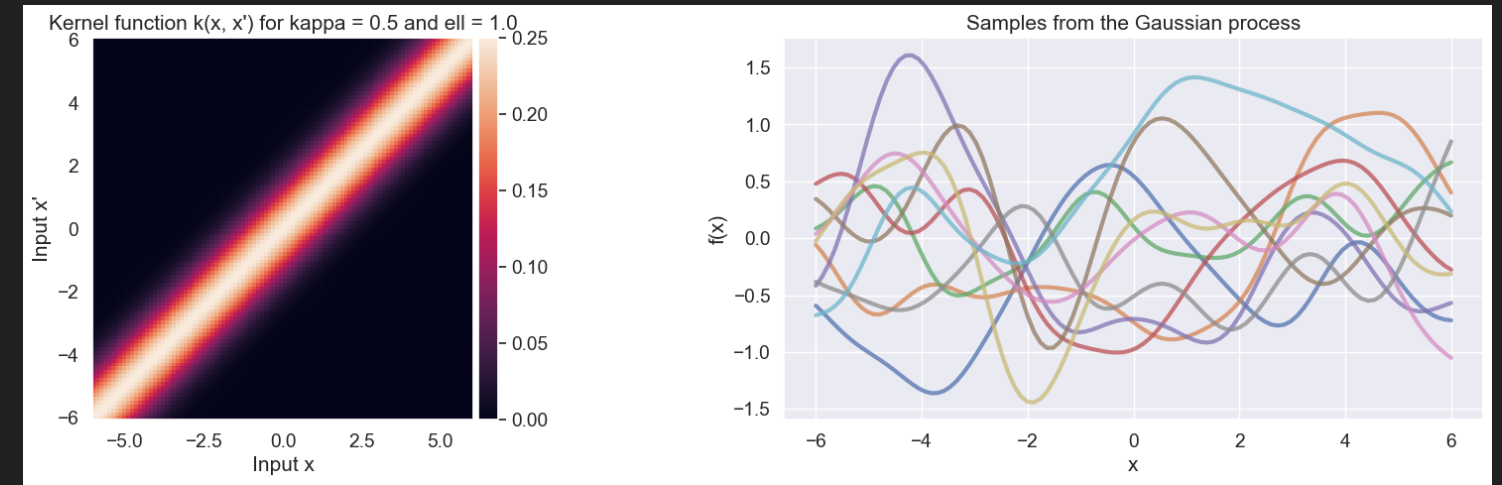
- Setting $\kappa = 0.5$ and $\ell = 1$ scales the covariance matrix. The amplitude of the function values is lower.
- We see faster decay meaning the function values become uncoupled quickly, leading to rougher functions.


**Task 2.5**: Generate samples from the Matern $\frac12$ and Matern $\frac{3}{2}$ kernels. How do they compare to samples from a squared exponential [**Discussion question**]

In [6]:
dict_of_kernels = {
    'Squared Exponential': squared_exponential,
    'Matern 1/2': matern12,
    'Matern 3/2': matern32
}

# Create an Nx1 vector of equidistant points in the range [-6, 6]
N = 100
X = jnp.linspace(-6, 6, N).reshape(-1, 1)
print(f"Shape of X: {X.shape}")

kappa = 1.
scale = 1.
num_samples = 10  # Define number of samples to generate
m = jnp.zeros(len(X))  # Define mean vector
# specify random seed
seed = 42
key = random.PRNGKey(42)

# Create figure with 3 subplots (one for each kernel)
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

# Loop through each kernel and plot samples
for i, (kernel_name, kernel_function) in enumerate(dict_of_kernels.items()):
    print(f"Kernel name: {kernel_name}, Function: {kernel_function}")
    # Construct kernel matrix for this kernel
    kernel_matrix = StationaryIsotropicKernel(kernel_function, kappa, scale).contruct_kernel(X, X)
    # Generate samples from this kernel
    f_samples = generate_samples(key, m, kernel_matrix, num_samples=num_samples, jitter=1e-8)
    # Plot the samples
    ax[i].plot(X, f_samples, alpha=0.75, linewidth=3)
    ax[i].set(xlabel='$x$', ylabel='$f(x)$', title=kernel_name)

plt.tight_layout()

Shape of X: (100, 1)
Kernel name: Squared Exponential, Function: <function squared_exponential at 0x0000013D46A45A80>
The shape of z's: (100, 10)
Shape of the mean, mu (100,)
Shape of mu after broadcasting (100, 1)
Shape of L: (100, 100)
Shape of f_samples (100, 10)
Kernel name: Matern 1/2, Function: <function matern12 at 0x0000013D46A45B20>
The shape of z's: (100, 10)
Shape of the mean, mu (100,)
Shape of mu after broadcasting (100, 1)
Shape of L: (100, 100)
Shape of f_samples (100, 10)
Kernel name: Matern 3/2, Function: <function matern32 at 0x0000013D46A45BC0>
The shape of z's: (100, 10)
Shape of the mean, mu (100,)
Shape of mu after broadcasting (100, 1)
Shape of L: (100, 100)
Shape of f_samples (100, 10)





# Mantern $\frac{1}{2}$ 
### Mantern $\frac{1}{2}$ Kernel with $\ell = 1$ and $\kappa = 1$
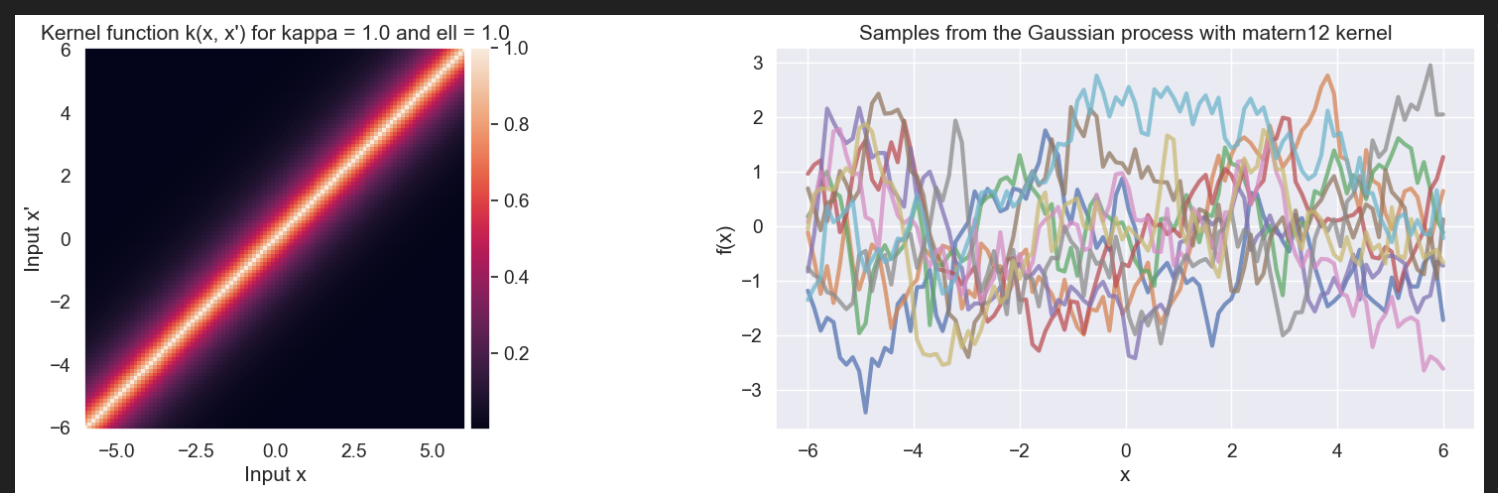

### Mantern $\frac{1}{2}$ Kernel with $\ell = 5$ and $\kappa = 1$


### Mantern $\frac{1}{2}$ Kernel with $\ell = 0.5$ and $\kappa = 1$
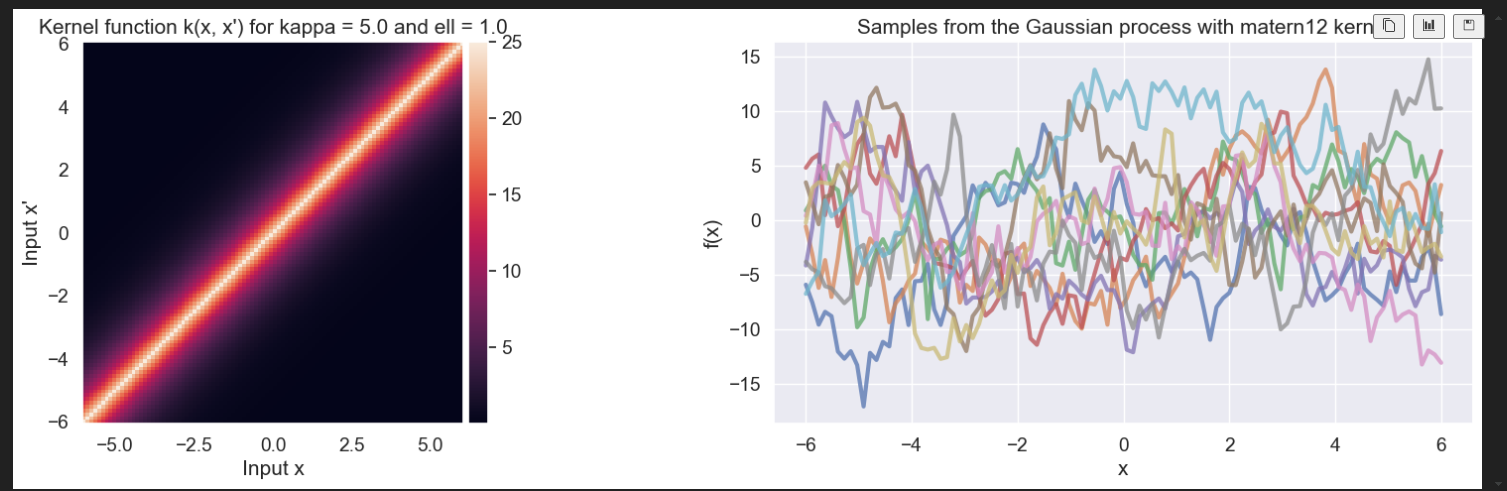


# Mantern $\frac{3}{2}$ 
### Mantern $\frac{3}{2}$ Kernel with $\ell = 1$ and $\kappa = 1$
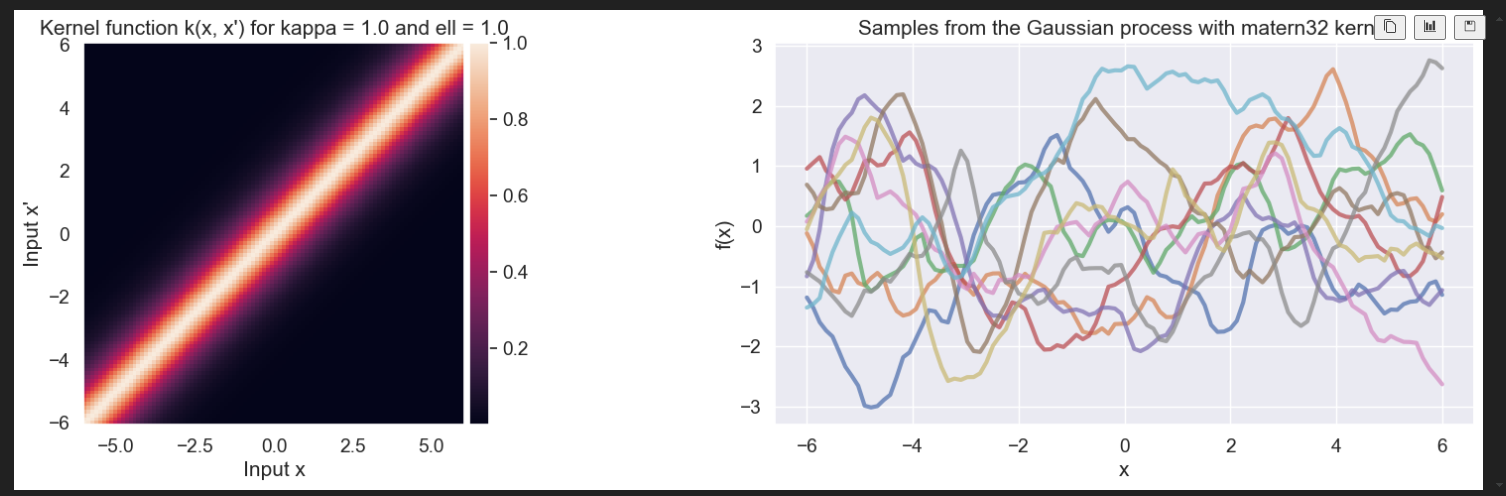

### Mantern $\frac{3}{2}$ Kernel with $\ell = 5$ and $\kappa = 1$
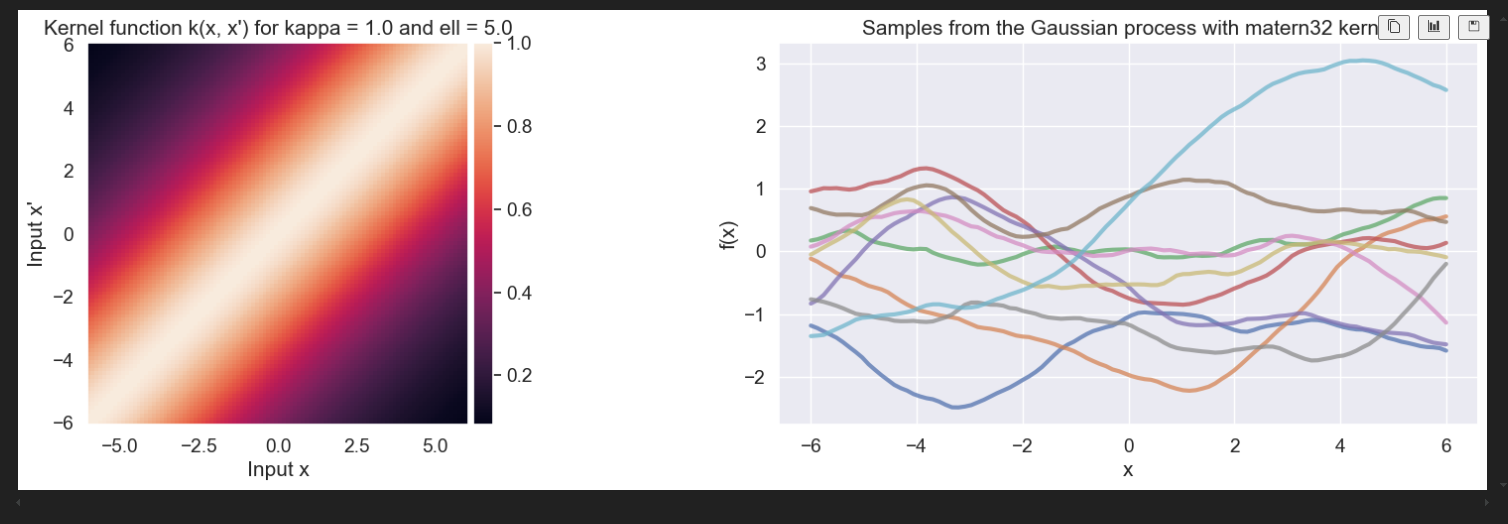

### Mantern $\frac{3}{2}$ Kernel with $\ell = 0.5$ and $\kappa = 1$


A simple way to understand and compare the three covariance functions (squared exponential, Matérn12, and Matérn32) is to study how they decay as a function of $||\tau|| = ||\mathbf{x}_n - \mathbf{x}_m||$:

In [7]:
tau = jnp.linspace(0, 8, 200)

kappa = 1
scale = 1

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tau, squared_exponential(tau, kappa=kappa, lengthscale=scale), linewidth=3, label='Squared exponential')
ax.plot(tau, matern12(tau, kappa=kappa, lengthscale=scale), linewidth=3, label='Matern1/2')
ax.plot(tau, matern32(tau, kappa=kappa, lengthscale=scale), linewidth=3, label='Matern3/2')
ax.set(xlabel='$||\\tau||$', ylabel='$k(||\\tau||)$', title='Decay of stationary covariance functions')
ax.legend()


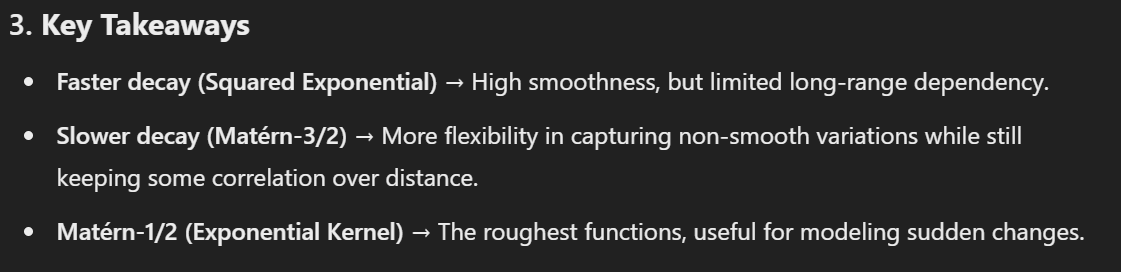

Suppose the distance between two input points $\mathbf{x}_n$ and $\mathbf{x}_m$ is  $d\cdot \ell$, i.e. $\|\tau\| = \|\mathbf{x}_n - \mathbf{x}_m\| = d\cdot\ell$.

**Task 2.6**: Using the squared exponential covariance function and assume $\kappa = 1$, what is the covariance between the function values $f(\mathbf{x}_n)$ and $f(\mathbf{x}_m)$ for $d = 0, 1, 2, 3, 4, 5$?

*Hints: Use eq. (5)*

______

$$\begin{align*}
    k_{\text{SE}}(\mathbf{x}_n, \mathbf{x}_m) = k(||\tau||) =  \kappa^2 \exp\left(-\frac{\|\tau\|^2_ 2}{2\ell^2}\right), \tag{5}
\end{align*}$$




# Part 3:  Non-linear regression using Gaussian processes

In this part, we will study how Gaussian processes can be used for non-linear regression. First, we will study a simple toy data set $\mathcal{D} = \left\lbrace (x_n, y_n) \right\rbrace_{n=1}^N$ for $N = 50$:



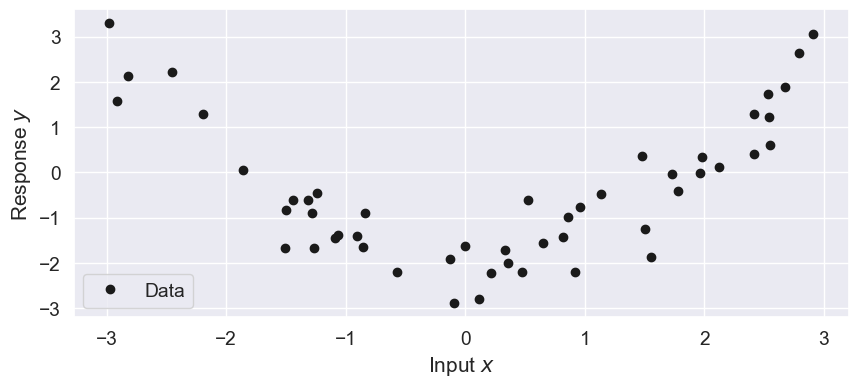

In [8]:
# load data
data = jnp.load('../data_exercise5.npz')
N = data['N']                                     # shape (N,)
Xtrain, ytrain = data['X'], data['y']             # shape (N, 1) and (N,)

# for predictions
Xstar = jnp.linspace(-3, 9, 100)[:, None]        # shape (100, 1)

# function for plotting
def plot_data(ax):
    ax.plot(Xtrain, ytrain, 'k.', markersize=12, label='Data')
    ax.grid(True)
    ax.set_xlabel('Input $x$')
    ax.set_ylabel('Response $y$')
    ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_data(ax)


We will adopt the following model

$$
\begin{align*}
y_n = f(\mathbf{x}_n) + e_n,
\end{align*}
$$

where $f(\mathbf{x})$ is assumed to be a Gaussian process. Assuming the noise $e_n$ is i.i.d. and Gaussian, the joint model for the training data becomes:

\begin{align*}
p(\mathbf{y}, \mathbf{f}) = \mathcal{N}\left(\mathbf{y}|\mathbf{f}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{f} | \mathbf{0}, \mathbf{K}\right)
\end{align*}

where $\mathbf{K}_{nm} = k(\mathbf{x}_n, \mathbf{x}_m)$ is the covariance matrix. 
We will also use the squared exponential and Matérn covariance functions in this part. Thus, this model (when using these covariance functions) has three hyperparameters in total: $\mathbf{\theta} = \left\lbrace \sigma, \kappa, \ell\right\rbrace$, where 

- $\sigma > 0$ is the standard deviation of the noise, 

- $\kappa > 0$ is the magnitude of the kernel,

- $\ell > 0$ is the lengthscale of the kernel. 

We will use $\mathbf{\theta}_K = \left\lbrace \kappa, \ell\ \right\rbrace$ to denote the hyperparameters of the kernel $K$ and $\mathbf{\theta}$ to denote all hyperparameters of the model.



Below you are given an incomplete implementation of a class for Gaussian process regression. The function called **compute_posterior** is supposed to the posterior mean and covariance matrix of the function values $f(\mathbf{x}^*)$ for input $\mathbf{x}^*$ conditioned on the training data $\mathbf{y}$.
The class contains a template for the following functions:

- `predict_f`: computes the posterior distribution of the function value $f(\mathbf{x}^*)$ for a new input, $\mathbf{x}^*$, i.e. $p(f^*|\mathbf{y}) = \mathcal{N}(f^*|\mu_{f^*}, \Sigma_{f^*})$
- `predict_y`: computes the posterior predictive distribution of for a new observation at new input, $\mathbf{x}^*$, i.e. $p(y^*|\mathbf{y}) = \mathcal{N}(y^*|\mu_{y^*}, \Sigma_{y^*})$
- `posterior_samples`: generates samples from the posterior distribution of $f^*$ for a set of inputs, i.e. $\mathbf{f}^* \sim p(f^*|\mathbf{y})$
- `log_marginal_likelihood`: evaluate the log marginal likelihood for a given set if hyperparameters $\theta$

In this part, we will focus on the first three and then come back to the marginal likelihood later.

**Task 3.1**: Complete the implementation of the function `predict_f` below.

*Hints*:
- *Look at eq. (17.34), (17.35) and (17.36) in Murphy1*
- *For computing matrix-vector prodcuts of the form $\mathbf{A}^{-1} \mathbf{x}$, `np.linalg.solve(A, x)` is numerically much more stable than `np.linalg.inv(A)@x`*.
- *If you prefer, you can move the class to a separate python module and import it to the notebook if you prefer not the scroll up and down during as you make it through the notebook*.




**Task 3.2**: Complete the implementation of the function `predict_y` below.

*Hints: Use the function `predict_f` you implemented in the previous task to do most of the work*

**Task 3.3**: Complete the implementation of the function `posterior_samples` below.

*Hints: The implementation of this should be easy and make heavy use of functions you already implemented*



Shape of Xtrain is (50, 1)
Shape of ytrain is (50, 1)
The shape of z's: (100, 50)
Shape of the mean, mu (100, 1)
Shape of mu after broadcasting (100, 1)
Shape of L: (100, 100)
Shape of f_samples (100, 50)
The shape of z's: (100, 50)
Shape of the mean, mu (100, 1)
Shape of mu after broadcasting (100, 1)
Shape of L: (100, 100)
Shape of f_samples (100, 50)


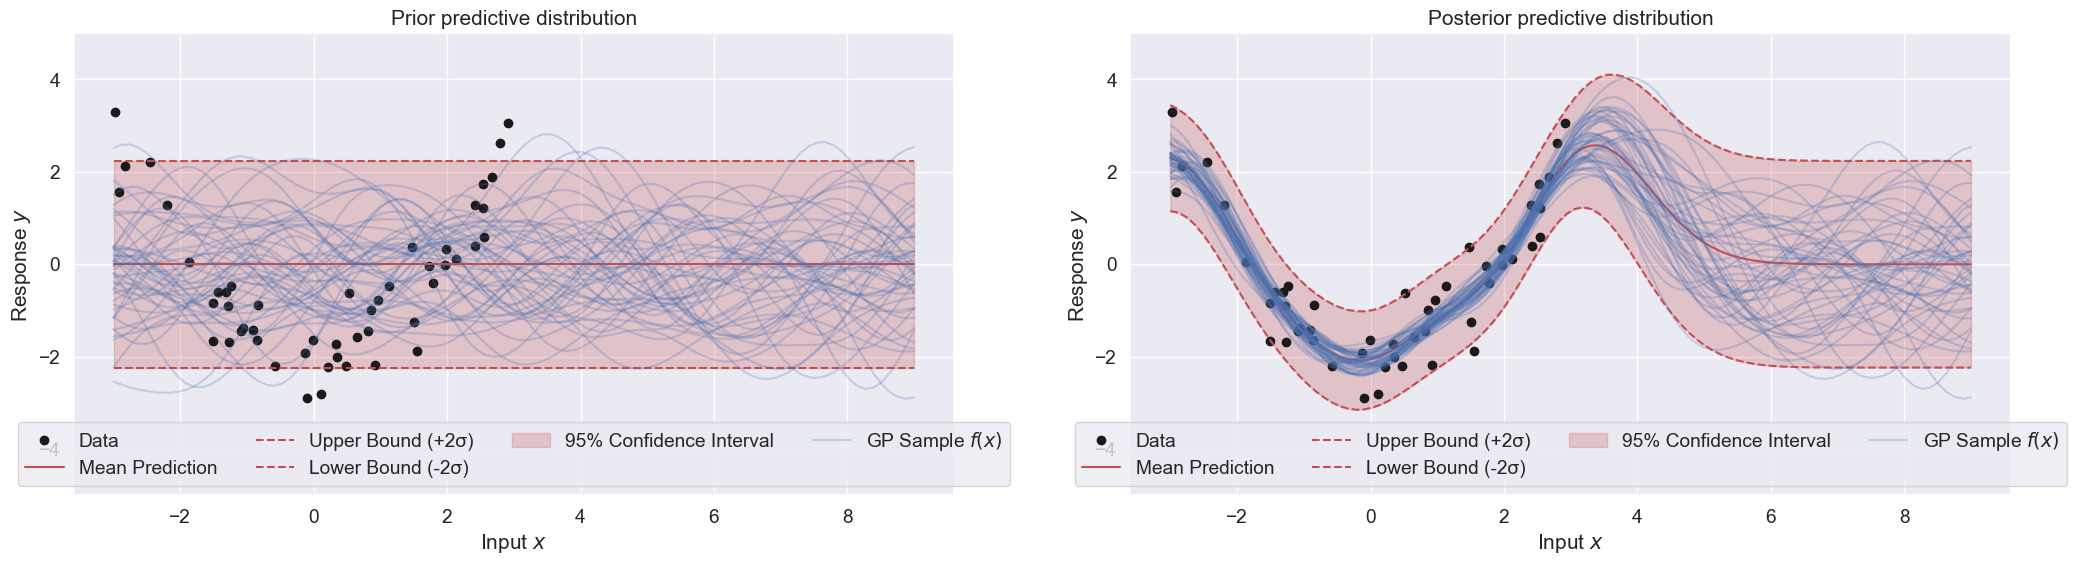

In [9]:
def plot_with_uncertainty(ax, Xp, gp, color='r', color_samples='b', title="", num_samples=0, seed=0):
    """
    Plot the predictive mean and uncertainty (confidence interval) from a Gaussian Process (GP).
    
    This function visualizes the mean prediction, confidence intervals, and optionally samples from the GP posterior.
    
    Arguments:
        ax            -- Matplotlib axis where the plot will be drawn.
        Xp            -- Input points where the GP is evaluated (shape NxD).
        gp            -- Trained Gaussian Process model.
        color         -- Color for the mean and confidence interval (default: red).
        color_samples -- Color for the sampled functions (default: blue).
        title         -- Title of the plot (default: empty string).
        num_samples   -- Number of function samples to draw from the posterior (default: 0, meaning no samples drawn).
        seed          -- Random seed for reproducibility (default: 0).
    """
    # Predict the mean and covariance from the GP at the given test points Xp
    mu, Sigma = gp.predict_y(Xp)
    mean = mu.ravel()  # Flatten mean vector
    std = jnp.sqrt(jnp.diag(Sigma))  # Extract standard deviation from the diagonal of the covariance matrix
    
    # Generate a random seed for sampling
    key = random.PRNGKey(seed)

    # Plot the predictive mean
    ax.plot(Xp, mean, color=color, label='Mean Prediction')
    
    # Plot confidence interval (±2 standard deviations for ~95% confidence)
    ax.plot(Xp, mean + 2*std, color=color, linestyle='--', label='Upper Bound (+2σ)')
    ax.plot(Xp, mean - 2*std, color=color, linestyle='--', label='Lower Bound (-2σ)')
    ax.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25, label='95% Confidence Interval')
    
    # Draw posterior samples if requested
    if num_samples > 0:
        fs = gp.posterior_samples(key, Xp, num_samples)  # Sample from the GP posterior
        ax.plot(Xp, fs[:, 0], color=color_samples, alpha=0.25, label="GP Sample $f(x)$")
        ax.plot(Xp, fs[:, 1:], color=color_samples, alpha=0.25)
    
    # Set the title of the plot
    ax.set_title(title)
    ax.legend()




class GaussianProcessRegression(object):

    def __init__(self, X, y, kernel, kappa=1., lengthscale=1., sigma=1/2, jitter=1e-8):
        """  
        Arguments:
            X                -- NxD input points
            y                -- Nx1 observed values 
            kernel           -- must be instance of the StationaryIsotropicKernel class
            jitter           -- non-negative scaler
            kappa            -- magnitude (positive scalar)
            lengthscale      -- characteristic lengthscale (positive scalar)
            sigma            -- noise std. dev. (positive scalar)
        """
        self.X = X
        self.y = y
        self.N = len(X)
        self.kernel = kernel
        self.jitter = jitter
        self.set_hyperparameters(kappa, lengthscale, sigma)
        self.check_dimensions()

    def check_dimensions(self):
        assert self.X.ndim == 2, f"The variable X must be of shape (N, D), however, the current shape is: {self.X.shape}"
        N, D = self.X.shape

        assert self.y.ndim == 2, f"The varabiel y must be of shape (N, 1), however. the current shape is: {self.y.shape}"
        assert self.y.shape == (N, 1), f"The varabiel y must be of shape (N, 1), however. the current shape is: {self.y.shape}"
        

    def set_hyperparameters(self, kappa, lengthscale, sigma):
        self.kappa = kappa
        self.lengthscale = lengthscale
        self.sigma = sigma

    def posterior_samples(self, key, Xstar, num_samples):
        """Generate samples from the posterior p(f^*|y, x^*) for each of the inputs in Xstar
        
        Implements sampling from the multivariate Gaussian:
        f_* ~ N(μ_{*|X}, Σ_{*|X})
        
        Arguments:
            key              -- jax random key for controlling the random number generator
            Xstar            -- PxD prediction points
            num_samples      -- number of samples to generate
        
        Returns:
            f_samples        -- numpy array of (P, num_samples) containing num_samples for each of the P inputs in Xstar
        """
        # Get posterior mean and covariance at test points
        mu, Sigma = self.predict_f(Xstar)
        
        # Use generate_samples to draw samples from this distribution:
        # f_* ~ N(μ_{*|X}, Σ_{*|X})
        f_samples = generate_samples(key, mu, Sigma, num_samples)

        assert (f_samples.shape == (len(Xstar), num_samples)), f"The shape of the posterior mu seems wrong. Expected ({len(Xstar)}, {num_samples}), but actual shape was {f_samples.shape}. Please check implementation"
        return f_samples
        
    def predict_y(self, Xstar):
        """Returns the posterior distribution of y^* evaluated at each of the points in x^* conditioned on (X, y)
        
        Implements the equations:
        μ_{y_*} = μ_{*|X}
        Σ_{y_*} = Σ_{*|X} + σ²I
        
        This differs from predict_f by adding observation noise σ² to the covariance.
        
        Arguments:
        Xstar       -- PxD prediction points
        
        Returns:
        mu          -- Px1 mean vector (μ_{y_*})
        Sigma_y     -- PxP covariance matrix (Σ_{y_*})
        """
        # Get posterior distribution of latent function f*
        mu, Sigma_ = self.predict_f(Xstar)
        
        # Add observation noise to covariance: Σ_{y_*} = Σ_{*|X} + σ²I
        Sigma_y = Sigma_ + self.sigma**2 * jnp.eye(len(Xstar))
        
        return mu, Sigma_y

    def predict_f(self, Xstar):
        """Returns the posterior distribution of f^* evaluated at each of the points in x^* conditioned on (X, y)
        
        Implements the equations:
        μ_{*|X} = K_{X,*}^T (K_{XX} + σ²I)^{-1} y
        Σ_{*|X} = K_{*,*} - K_{X,*}^T (K_{XX} + σ²I)^{-1} K_{X,*}
        
        Arguments:
        Xstar -- PxD prediction points
        
        Returns:
        mu    -- Px1 mean vector (μ_{*|X})
        Sigma -- PxP covariance matrix (Σ_{*|X})
        """
        # Compute kernel matrices
        K_X_X = self.kernel.contruct_kernel(self.X, self.X, self.kappa, self.lengthscale, self.jitter)  # K_{XX}
        K_star_star = self.kernel.contruct_kernel(Xstar, Xstar, self.kappa, self.lengthscale, self.jitter)  # K_{*,*}
        K_x_star = self.kernel.contruct_kernel(self.X, Xstar, self.kappa, self.lengthscale)  # K_{X,*}
        
        # Add noise to training covariance: K_{XX} + σ²I
        K_sigma = K_X_X + self.sigma**2 * jnp.eye(len(self.X))
        
        # Compute (K_{XX} + σ²I)^{-1} y efficiently without explicit inversion
        alpha = jnp.linalg.solve(K_sigma, self.y)
        
        # Compute mean: μ_{*|X} = K_{X,*}^T (K_{XX} + σ²I)^{-1} y
        mu = K_x_star.T @ alpha
        
        # Compute (K_{XX} + σ²I)^{-1} K_{X,*} efficiently
        v = jnp.linalg.solve(K_sigma, K_x_star)
        
        # Compute covariance: Σ_{*|X} = K_{*,*} - K_{X,*}^T (K_{XX} + σ²I)^{-1} K_{X,*}
        Sigma = K_star_star - K_x_star.T @ v

        # sanity check for dimensions
        assert (mu.shape == (len(Xstar), 1)), f"The shape of the posterior mu seems wrong. Expected ({len(Xstar)}, 1), but actual shape was {mu.shape}. Please check implementation"
        assert (Sigma.shape == (len(Xstar), len(Xstar))), f"The shape of the posterior Sigma seems wrong. Expected ({len(Xstar)}, {len(Xstar)}), but actual shape was {Sigma.shape}. Please check implementation"

        return mu, Sigma
    
    def log_marginal_likelihood(self, kappa, lengthscale, sigma):
        """Evaluate the log marginal likelihood p(y|X,θ) given the hyperparameters
        
        Implements the equation:
        log p(y|X,θ) = -1/2 * (y^T (K + σ²I)^{-1} y + log|K + σ²I| + n*log(2π))
        
        Efficient implementation uses Cholesky decomposition for numerical stability.
        
        Arguments:
            kappa       -- magnitude parameter (positive scalar) 
            lengthscale -- characteristic lengthscale (positive scalar)
            sigma       -- noise std. dev. (positive scalar)
        
        Returns:
            log_marginal -- scalar value of log marginal likelihood
        """
        # Compute kernel matrix with current hyperparameters
        K = self.kernel.contruct_kernel(self.X, self.X, kappa, lengthscale)  # K
        
        # Add noise variance: C = K + σ²I
        C = K + sigma**2 * jnp.identity(self.N)
        
        # Compute Cholesky decomposition: C = LL^T
        L = jnp.linalg.cholesky(C)
        
        # Solve L*v = y efficiently
        v = jnp.linalg.solve(L, self.y)
        
        # Compute log determinant term: log|C| = 2*sum(log(diag(L)))
        # Note: Factor of 2 is accounted for in the constant term
        logdet_term = jnp.sum(jnp.log(jnp.diag(L)))
        
        # Compute quadratic term: 1/2 * y^T C^{-1} y = 1/2 * ||v||²
        quad_term = 0.5 * jnp.sum(v**2)
        
        # Constant term: -1/2 * n * log(2π)
        const_term = -0.5 * self.N * jnp.log(2*jnp.pi)
        
        # Combine terms: log p(y|X,θ) = const_term - logdet_term - quad_term
        return const_term - logdet_term - quad_term
        

#KAPPA = 1.0
#ELL = 1
#SIGMA = 0.  # New noise standard deviation

# instantiate kernel
kernel_ = StationaryIsotropicKernel(kernel_fun=squared_exponential)

# instantiate GP without data (hence, posterior=prior) and with data
gp_prior_1 = GaussianProcessRegression(jnp.zeros((0, 1)), jnp.zeros((0, 1)), kernel_)
gp_post_1 = GaussianProcessRegression(Xtrain, ytrain, kernel_)
#gp_post_1.set_hyperparameters(kappa=KAPPA, lengthscale=ELL, sigma=SIGMA)


print(f"Shape of Xtrain is {Xtrain.shape}")
print(f"Shape of ytrain is {ytrain.shape}")


# plot
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
plot_data(ax[0])
plot_with_uncertainty(ax[0], Xstar, gp_prior_1, title='Prior predictive distribution', num_samples=50)
ax[0].legend(loc='lower center', ncol=4)
ax[0].set_ylim((-5, 5))

plot_data(ax[1])
plot_with_uncertainty(ax[1], Xstar, gp_post_1, title='Posterior predictive distribution', num_samples=50)
ax[1].legend(loc='lower center', ncol=4)
ax[1].set_ylim((-5, 5));

If the code has been implemented correct, then the left figure above shows 30 samples from the prior predictive distribution along with the mean and 95% interval from the prior predictive distribution, whereas the right figure shows the same quantities for the posterior predictive distribution.

**Task 3.4**: Inspect the plots above. How does the prior and posterior predictive differ in: a) regions close to the data points? b) in regions far from the data point? [**Discussion question**]


#### The prior predictive distribution
- Shows possible function samples before observing any data.
- No information about the underlying function, so all samples appear random.
- Mean function is flat (zero) and the variance is high, leading to a wide range of possible functions.
- Confidence intervals are wide, meaning that the function values can vary a lot.

#### The posterior predictive distribution
- Incoprotates the information from the data.
- Function samples now conform to data points, meaning they pass through observed locations while still allowing uncertainty in unexplored regions.
- Mean function is close to the data points, and the variance is lower, leading to a narrower range of possible functions.
- Confidence intervals are narrow (at places with observed data points), meaning that the function values are more certain.

### Key differences 
(a) Regions Close to Data Points
- Prior Predictive: Before seeing any data, the model assumes a wide range of possible functions, so the function samples fluctuate significantly without any clear pattern.
- Posterior Predictive: Near observed data, function samples become tightly constrained around the data points.
    - The mean function aligns closely with data.
    - The uncertainty (confidence interval) is small because the GP has high confidence in regions where data is present.
    - Function samples exhibit smooth interpolation between observed points.

(b) Regions Far from Data Points
- Prior Predictive: The variance remains constant across all input values since no data has been seen.
- Posterior Predictive: In regions with no data, the uncertainty increases because the model has no knowledge of the function behavior.
    - The confidence interval widens, meaning function samples can deviate significantly.
    - The GP reverts to the prior mean function (usually zero in this case).

**Task 3.5**: Explain this behavior using the equations for the posterior mean and covariance of $f^*$ (and what you saw in part 2)? 


#### Explanation for Task 3.5: GP Behavior from Posterior Equations

To explain the behavior observed in Task 3.4, let's examine the equations for the posterior mean and covariance from the Gaussian Process:

##### Posterior Mean and Covariance Equations

When we condition on observed data, the GP posterior mean and covariance for test points $f^*$ (at $X^*$) are given by:

- **Posterior mean:**
    $$
    \mu_{*|X} = K_{X,*}^T (K_{XX} + \sigma^2 I)^{-1} y
    $$
    This shows that the mean prediction at $X^*$ is a linear combination of the observed targets $y$, weighted by the covariance between the test and training points, and adjusted for the noise.

- **Posterior covariance:**
    $$
    \Sigma_{*|X} = K_{*,*} - K_{X,*}^T (K_{XX} + \sigma^2 I)^{-1} K_{X,*}
    $$
    The posterior covariance at the test points is the prior covariance minus a term that reflects how much information the training data provides about $f^*$. Where the test points are close to training data, this term is large, reducing uncertainty; far from data, it is small, so the posterior variance approaches the prior.

**Interpretation:**  
- Near observed data, $K_{X,*}$ is large, so the mean is strongly influenced by $y$ and the variance is reduced.
- Far from data, $K_{X,*}$ is small, so the mean reverts to the prior mean (often zero), and the variance approaches the prior variance.
- This matches the behavior seen in the plots: low uncertainty and mean close to data near observations, high uncertainty and mean reverting to prior far from data.  
- The structure of $K$ (from the kernel function) determines how quickly this transition happens, as seen in Part 2.

Where:
- `K_{X,*}` is the covariance between training and test points
- `K_{XX}` is the covariance between training points
- `K_{*,*}` is the covariance between test points (prior covariance)
- `σ²` is the noise variance
- `y` is the observed training data

#### Explanation of Behavior

##### (a) Regions Close to Data Points

When test points x* are close to training points:

1. **Large K_{X,*} values**: The kernel function (e.g., squared exponential) produces high correlations between nearby points
   
2. **Mean prediction**: The term `K_{X,*}^T (K_{XX} + σ²I)^{-1} y` dominates, making the posterior mean closely follow the observed data points

3. **Reduced variance**: The term `K_{X,*}^T (K_{XX} + σ²I)^{-1} K_{X,*}` becomes large, significantly reducing the posterior covariance from the prior `K_{*,*}`

4. **Result**: Tight confidence intervals and smooth interpolation through data points

##### (b) Regions Far from Data Points

When test points x* are far from training points:

1. **Small K_{X,*} values**: The kernel function produces near-zero correlations for distant points

2. **Mean prediction**: As `K_{X,*} → 0`, the posterior mean `μ_{*|X} → 0` (reverts to prior mean)

3. **Variance approaches prior**: As `K_{X,*} → 0`, the posterior covariance `Σ_{*|X} → K_{*,*}` (reverts to prior covariance)

4. **Result**: Wide confidence intervals and high uncertainty, similar to the prior

##### Key Insight

The kernel function controls information flow between points:
- **High correlation** (nearby points) → **Strong influence** from data → **Low uncertainty**
- **Low correlation** (distant points) → **Weak influence** from data → **High uncertainty**

This behavior is fundamental to GPs and explains why they provide:
- Accurate interpolation near observed data
- Principled uncertainty quantification
- Smooth reversion to the prior in unexplored regions

The smoothness of this transition is controlled by the kernel's lengthscale parameter, which determines how quickly correlations decay with distance.


**Task 3.6**: Visualize the prior covariance matrix for $f^*$ and posterior covariance for $f^*$ matrix side-by-side as images and comment on what you see



In [10]:
_,Sigma_prior = gp_prior_1.predict_f(Xstar)
_,Sigma_posterior = gp_post_1.predict_f(Xstar)



print(Sigma_prior.shape)

(100, 100)


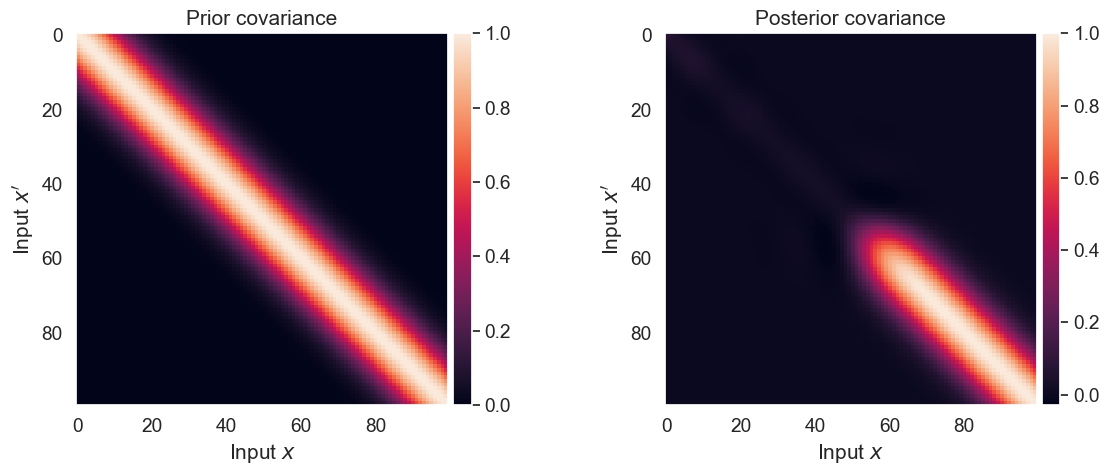

In [11]:
# Create figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Left: Covariance Matrix
im = ax[0].imshow(Sigma_prior)
ax[0].set(xlabel='Input $x$', ylabel="Input $x'$", title='Prior covariance')
ax[0].grid(False)
add_colorbar(im, fig, ax[0])

# Right: Function Plot
im = ax[1].imshow(Sigma_posterior)
ax[1].set(xlabel='Input $x$', ylabel="Input $x'$", title='Posterior covariance');
ax[1].grid(False)
add_colorbar(im, fig, ax[1])

plt.tight_layout()
plt.show()

#

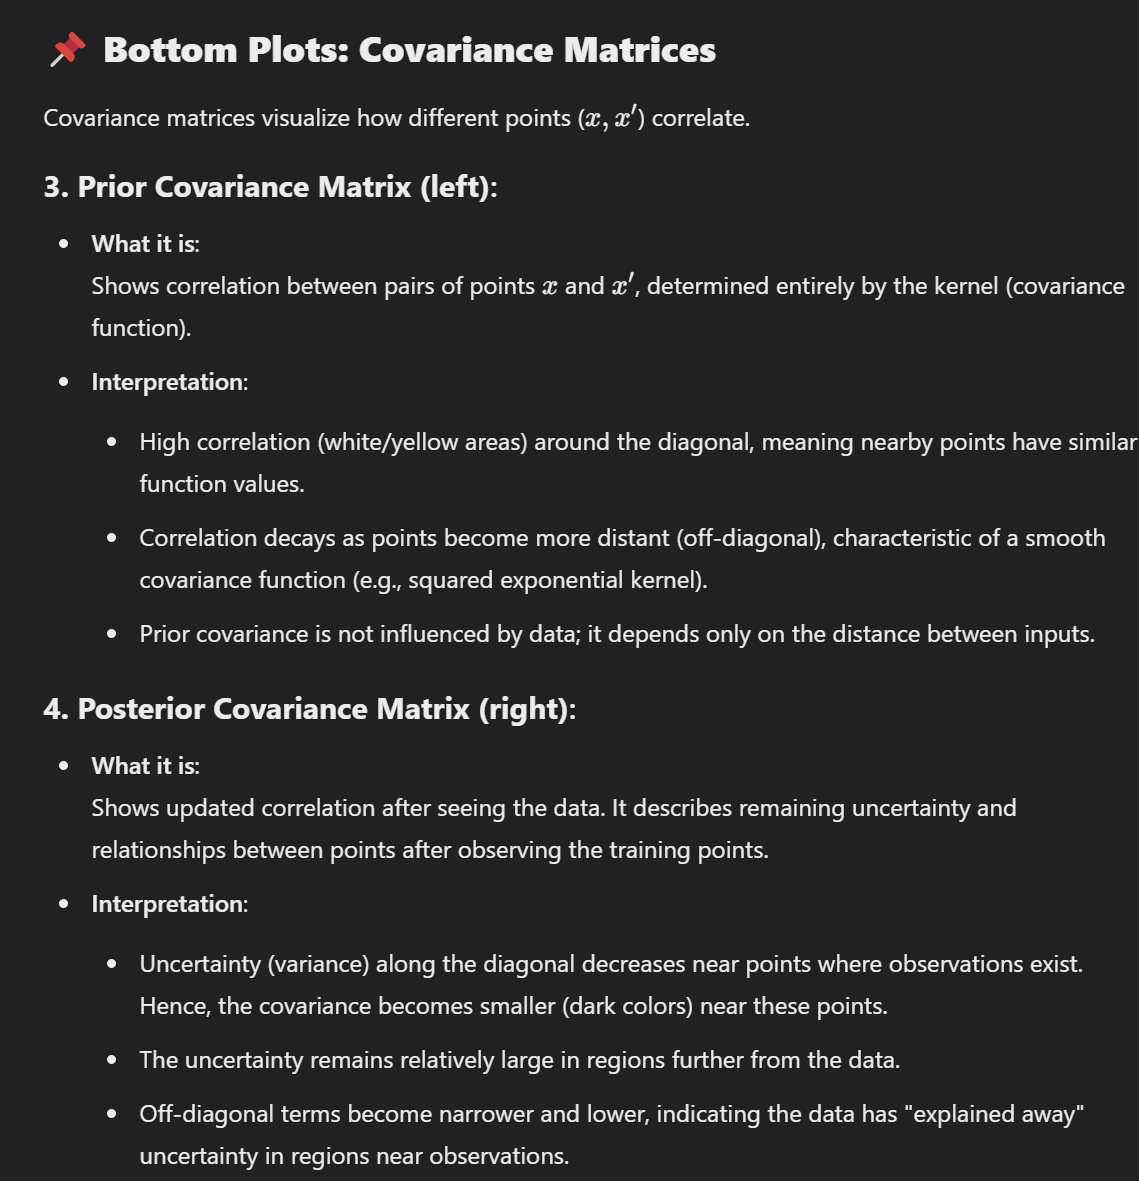

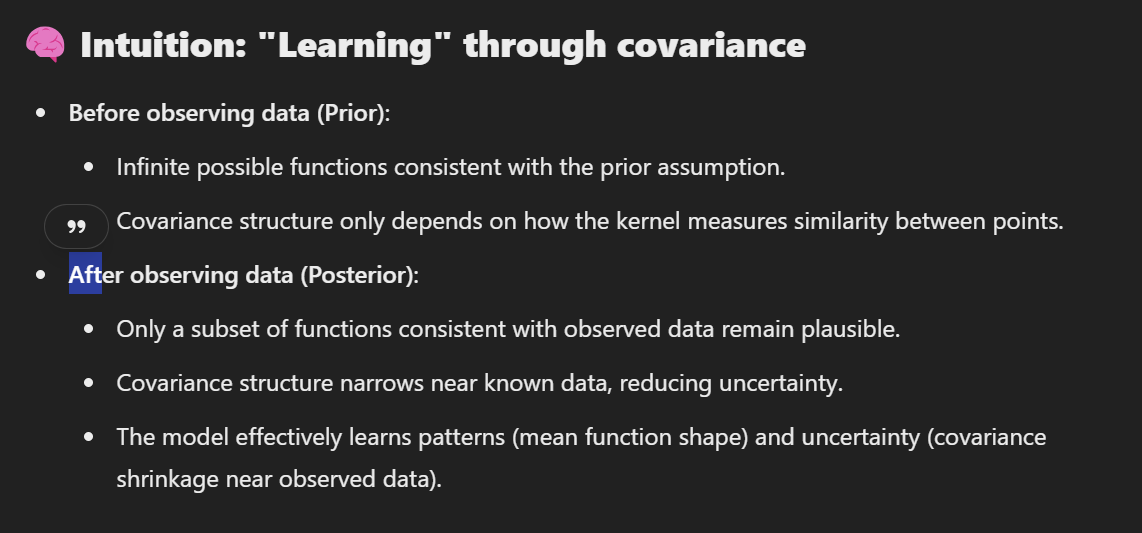

**Task 3.7**: Change the values of kappa and scale and explain how it affects the prior and posterior. For example, what happens if you choose the lengthscale $\ell$ to be either 0.25, 1, or 5 while keeping $\kappa = 1$ and $\sigma = \frac12$? Do similar experiments with $\sigma$ and $\kappa$.  
[**Discussion question**]

# Solution for Task 3.7: Effects of Hyperparameters on GP Prior and Posterior

## Understanding the Hyperparameters

The Gaussian Process has three key hyperparameters:
- **κ (kappa)**: Output scale/magnitude  
- **ℓ (lengthscale)**: Controls smoothness and correlation decay  
- **σ (sigma)**: Observation noise standard deviation  

---

## 1. Lengthscale ($\ell$) Effects

### Small lengthscale ($\ell = 0.25$)
- **Prior behavior:**
    - Functions vary rapidly (less smooth)
    - Nearby points are less correlated
    - Narrow diagonal band in covariance matrix
- **Posterior behavior:**
    - Fits data points very locally
    - Quickly reverts to prior between data points
    - Higher uncertainty between observations
    - Can lead to "wiggly" interpolation

### Medium lengthscale ($\ell = 1.0$)
- **Prior behavior:**
    - Moderate smoothness
    - Balanced correlation structure
    - Standard diagonal decay in covariance
- **Posterior behavior:**
    - Smooth interpolation through data
    - Reasonable uncertainty away from data
    - Good balance between fitting and generalization

### Large lengthscale ($\ell = 5.0$)
- **Prior behavior:**
    - Very smooth functions
    - Long-range correlations
    - Wide diagonal band in covariance matrix
- **Posterior behavior:**
    - Very smooth, almost linear interpolation
    - Slow reversion to prior
    - May underfit local variations
    - Lower uncertainty overall

---

## 2. Kappa ($\kappa$) Effects

### Small kappa ($\kappa = 0.1$)
- Reduces function amplitude
- Smaller prior variance
- Functions closer to zero mean
- Narrower confidence intervals

### Large kappa ($\kappa = 10.0$)
- Increases function amplitude
- Larger prior variance
- Functions can deviate far from zero
- Wider confidence intervals

---

## 3. Sigma ($\sigma$) Effects

### Small sigma ($\sigma = 0.01$)
- Assumes very low observation noise
- Posterior passes very close to data points
- Tight fit to observations
- Risk of overfitting

### Large sigma ($\sigma = 2.0$)
- Assumes high observation noise
- Posterior doesn't pass exactly through data
- Smoother interpolation
- More robust to outliers

---

## Key Insights

- **Lengthscale ($\ell$)** controls the smoothness and how quickly the GP forgets data:
    - Small $\ell$ → local influence, wiggly functions
    - Large $\ell$ → global influence, smooth functions

- **Kappa ($\kappa$)** controls the vertical scale of variations:
    - Small $\kappa$ → functions stay close to mean
    - Large $\kappa$ → functions can vary widely

- **Sigma ($\sigma$)** controls the noise assumption:
    - Small $\sigma$ → trust data more (tight fit)
    - Large $\sigma$ → trust data less (smooth fit)

---

## Practical Recommendations

- Start with $\ell$ ≈ typical distance between data points
- Set $\kappa$ based on expected function magnitude
- Set $\sigma$ based on known measurement noise
- Use cross-validation or marginal likelihood to optimize

---

## Interactive Effects

These parameters interact:
- Large $\kappa$ with small $\ell$ → very wiggly, high-amplitude functions
- Small $\kappa$ with large $\ell$ → smooth, low-amplitude functions
- $\sigma$ relative to $\kappa$ determines how much to trust data vs prior

The optimal values depend on your specific problem and the nature of your data!



**Task 3.8**: Experiment with the two other kernerls, the Matérn $\frac12$ and the Matérn $\frac{3}{2}$. How does that affect the fits and the predictions? [**Discussion question**]

# Solution for Task 3.8: Comparing Different Kernel Functions

## Overview of Kernel Functions

The kernel function determines the properties of functions drawn from the GP prior and posterior. Different kernels encode different assumptions about function smoothness and behavior.

## 1. Kernel Mathematical Properties

### Squared Exponential (SE) Kernel
```
k(x, x') = κ² exp(-||x - x'||² / (2ℓ²))
```
- Infinitely differentiable
- Produces infinitely smooth functions
- Strong correlations decay smoothly with distance

### Matérn-1/2 Kernel
```
k(x, x') = κ² exp(-||x - x'|| / ℓ)
```
- Equivalent to exponential kernel
- Not differentiable (continuous but not smooth)
- Produces rough, non-differentiable functions

### Matérn-3/2 Kernel
```
k(x, x') = κ² (1 + √3||x - x'||/ℓ) exp(-√3||x - x'||/ℓ)
```
- Once differentiable
- Produces functions with continuous first derivatives
- Intermediate smoothness

## 2. Prior Behavior Comparison

### Squared Exponential
```python
kernel_se = StationaryIsotropicKernel(kernel_fun=squared_exponential)
gp_se = GaussianProcessRegression(Xtrain, ytrain, kernel_se)
```
**Prior characteristics:**
- Very smooth sample functions
- Gradual changes
- No sharp features
- Unrealistic for many physical processes

### Matérn-1/2
```python
kernel_matern12 = StationaryIsotropicKernel(kernel_fun=matern12)
gp_matern12 = GaussianProcessRegression(Xtrain, ytrain, kernel_matern12)
```
**Prior characteristics:**
- Rough, jagged sample functions
- Abrupt changes possible
- Non-differentiable paths
- Similar to Brownian motion

### Matérn-3/2
```python
kernel_matern32 = StationaryIsotropicKernel(kernel_fun=matern32)
gp_matern32 = GaussianProcessRegression(Xtrain, ytrain, kernel_matern32)
```
**Prior characteristics:**
- Moderately smooth functions
- Continuous derivatives
- More realistic for physical processes
- Balance between smoothness and flexibility

## 3. Posterior Behavior Comparison

### Squared Exponential Posterior
**Characteristics:**
- Extremely smooth interpolation
- May oversmooth real data
- Excellent for truly smooth processes
- Can miss sharp features

### Matérn-1/2 Posterior
**Characteristics:**
- Can capture sharp changes
- More flexible fitting
- Higher risk of overfitting
- Good for discontinuous processes

### Matérn-3/2 Posterior
**Characteristics:**
- Balanced smoothness
- Can capture moderate variations
- Less prone to oversmoothing
- Good general-purpose choice

## 4. Visual Differences

```python
# Comparison visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

kernels = {
    'Squared Exponential': squared_exponential,
    'Matérn-1/2': matern12,
    'Matérn-3/2': matern32
}

for i, (name, kernel_fun) in enumerate(kernels.items()):
    kernel = StationaryIsotropicKernel(kernel_fun=kernel_fun)
    
    # Prior
    gp_prior = GaussianProcessRegression(jnp.zeros((0,1)), jnp.zeros((0,1)), kernel)
    plot_with_uncertainty(axes[i,0], Xstar, gp_prior, 
                         title=f'{name} Prior', num_samples=5)
    
    # Posterior
    gp_post = GaussianProcessRegression(Xtrain, ytrain, kernel)
    plot_with_uncertainty(axes[i,1], Xstar, gp_post, 
                         title=f'{name} Posterior', num_samples=5)
    
fig.tight_layout()
plt.show()
```

## 5. Practical Implications

### When to Use Each Kernel

**Squared Exponential:**
- Physics simulations
- Temperature modeling
- Smooth natural processes
- When derivatives matter

**Matérn-1/2:**
- Financial time series
- Rough terrain modeling
- Discontinuous processes
- When smoothness is unrealistic

**Matérn-3/2:**
- General regression tasks
- Engineering applications
- Biological processes
- Default choice for many problems

## 6. Key Insights

1. **Smoothness Spectrum:**
   - Matérn-1/2 (roughest) → Matérn-3/2 (moderate) → SE (smoothest)

2. **Flexibility vs. Overfitting:**
   - Rougher kernels are more flexible but risk overfitting
   - Smoother kernels are more constrained but may underfit

3. **Physical Realism:**
   - SE often too smooth for real-world data
   - Matérn-3/2 offers good balance
   - Matérn-1/2 for truly rough processes

4. **Computational Considerations:**
   - All have similar computational complexity
   - Choice should be based on problem characteristics

## 7. Practical Example

```python
# Comparing predictions on noisy data
noisy_y = ytrain + 0.1 * random.normal(key, shape=ytrain.shape)

for kernel_name, kernel_fun in kernels.items():
    kernel = StationaryIsotropicKernel(kernel_fun=kernel_fun)
    gp = GaussianProcessRegression(Xtrain, noisy_y, kernel)
    gp.set_hyperparameters(kappa=1.0, lengthscale=1.0, sigma=0.1)
    
    mu, _ = gp.predict_y(Xstar)
    print(f"{kernel_name}: Mean prediction range = [{mu.min():.3f}, {mu.max():.3f}]")
```

## 8. Covariance Matrix Visualization

The covariance matrices show distinct patterns:

- **SE**: Smooth decay from diagonal, very gradual
- **Matérn-1/2**: Sharp decay from diagonal, narrow band
- **Matérn-3/2**: Intermediate decay, wider band than Matérn-1/2

```python
# Visualize covariance matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, kernel_fun) in enumerate(kernels.items()):
    kernel = StationaryIsotropicKernel(kernel_fun=kernel_fun)
    gp = GaussianProcessRegression(jnp.zeros((0,1)), jnp.zeros((0,1)), kernel)
    _, Sigma = gp.predict_f(Xstar)
    
    im = axes[i].imshow(Sigma)
    axes[i].set_title(f'{name} Covariance')
    axes[i].set(xlabel='Input x', ylabel="Input x'")
    add_colorbar(im, fig, axes[i])

plt.tight_layout()
plt.show()
```

## 9. Effect on Uncertainty Quantification

Different kernels provide different uncertainty estimates:

- **SE**: Uncertainty grows very slowly away from data
- **Matérn-1/2**: Uncertainty grows quickly away from data
- **Matérn-3/2**: Balanced uncertainty growth

This affects:
- Extrapolation behavior
- Confidence interval width
- Decision-making under uncertainty

## Recommendation

For most applications, start with Matérn-3/2 as it provides a good balance between flexibility and smoothness. Only use SE if you know your process is infinitely smooth, and Matérn-1/2 if you expect rough, non-differentiable behavior.

### Selection Guidelines:

1. **Unknown smoothness**: Start with Matérn-3/2
2. **Known smooth process**: Use Squared Exponential
3. **Known rough process**: Use Matérn-1/2
4. **Physical systems**: Often Matérn-3/2 or Matérn-5/2
5. **Financial data**: Often Matérn-1/2 or Matérn-3/2

Remember: The choice of kernel is a modeling decision that should reflect your prior knowledge about the function's behavior.

In [12]:
# Squared Exponential prior
#kernel_se    = StationaryIsotropicKernel(kernel_fun=squared_exponential)
#gp_se_prior  = GaussianProcessRegression(jnp.zeros((0,1)), jnp.zeros((0,1)), kernel_se)
#
## Matérn-1/2 prior
#kernel_m12   = StationaryIsotropicKernel(kernel_fun=matern12)
#gp_m12_prior = GaussianProcessRegression(jnp.zeros((0,1)), jnp.zeros((0,1)), kernel_m12)
#
## Matérn-3/2 prior
#kernel_m32   = StationaryIsotropicKernel(kernel_fun=matern32)
#gp_m32_prior = GaussianProcessRegression(jnp.zeros((0,1)), jnp.zeros((0,1)), kernel_m32)
#
## Visualize sample functions
#fig, axes = plt.subplots(3, 1, figsize=(8, 10))
#Xstar = jnp.linspace(0, 1, 100)[:, None]
#for ax, gp, title in zip(axes, 
#    [gp_se_prior, gp_m12_prior, gp_m32_prior],
#    ['SE Prior', 'Matérn-1/2 Prior', 'Matérn-3/2 Prior']):
#    plot_with_uncertainty(ax, Xstar, gp, num_samples=5)
#    ax.set_title(title)
#plt.tight_layout()


# Part 4:  Hyperparameter optimization using the marginal likelihood

Before we can apply this model in practice, we will study how we can use the ***marginal likelihood*** to estimate the hyperparameters of the model. If we let $\mathbf{\theta} \in \mathbb{R}^K$ denote all of our hyperparameters, then the **evidence approximation** suggests that we can estimate $\mathbf{\theta}$ as follows

\begin{align*}
\hat{\mathbf{\theta}} = \arg\max\limits_{\mathbf{\theta}} \ln p(\mathbf{y}|\mathbf{\theta}),
\end{align*}

where $p(\mathbf{y}|\mathbf{\theta})$ is the marginal likelihood of the model (see eq. (17.52) in Murphy1).


**Task 4.1**: Go back up to the implementation of `GaussianProcessRegression`-class and complete the implementation of the function `log_marginal_likelihood`

- *Hints: The expression for the marginal likelihood contains both determinants and matrix inverse, which can be numerically fragile and lead to underflow/overflow. Hence, you need to be careful with the numerical implementation. See the details in the slides for this week*

If your implementation is correct, then the code below implement an optimization routine for the marginal likelihood. Note that we re-parametrize the hyperparameters in the log-domain before optimizing to ensure that the hyperparameter remain positive. We rely and the package `autograd` for computing the gradients.

In [13]:
def optimize_hyperparameters(gp, theta_init):

    # define optimization objective as the negative log marginal likelihood
    objective = lambda params: -gp.log_marginal_likelihood(jnp.exp(params[0]), jnp.exp(params[1]), jnp.exp(params[2]))

    # optimize using gradients
    res = minimize(value_and_grad(objective), jnp.log(theta_init), jac=True)

    # check for success
    if not res.success:
        print('Warning: optimization failed!')

    # return resultss
    theta = jnp.exp(res.x)
    return theta


Let's run it on our toy dataset:

Estimated hyperparameters
	sigma: 0.59
	kappa: 2.92
	scale: 1.82
The shape of z's: (100, 30)
Shape of the mean, mu (100, 1)
Shape of mu after broadcasting (100, 1)
Shape of L: (100, 100)
Shape of f_samples (100, 30)
The shape of z's: (100, 30)
Shape of the mean, mu (100, 1)
Shape of mu after broadcasting (100, 1)
Shape of L: (100, 100)
Shape of f_samples (100, 30)


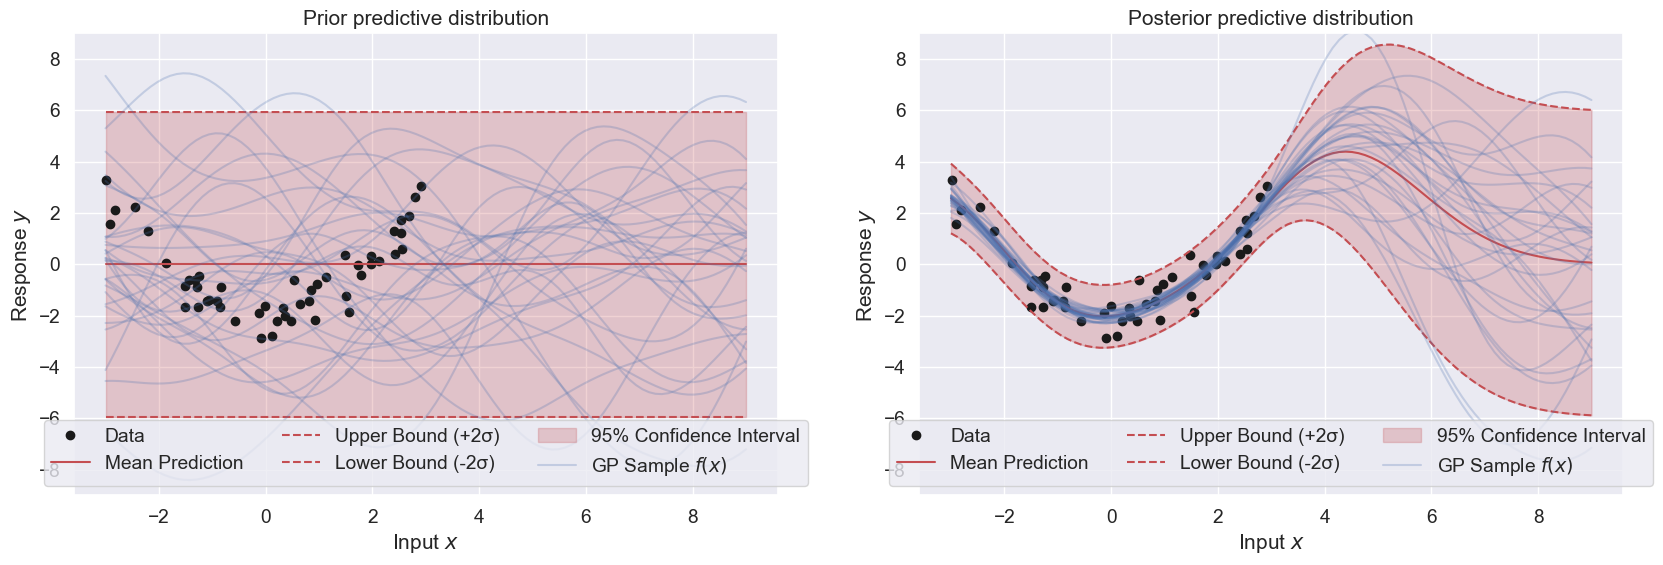

In [14]:
# Instantiate the squared exponential kernel with default hyperparameters
kernel = StationaryIsotropicKernel(kernel_fun=squared_exponential)

# Create a GP prior object (no data, so prior only)
gp_prior = GaussianProcessRegression(jnp.zeros((0, 1)), jnp.zeros((0, 1)), kernel)

# Create a GP posterior object (with training data)
gp_post = GaussianProcessRegression(Xtrain, ytrain, kernel)

# Optimize hyperparameters (kappa, lengthscale, sigma) using marginal likelihood
# Initial guess for all hyperparameters is 1
theta_hat = optimize_hyperparameters(gp_post, theta_init=jnp.array([1,1,1]))

# Extract optimized hyperparameters
kappa_hat, scale_hat, sigma_hat = theta_hat

# Print the estimated hyperparameters
print('Estimated hyperparameters')
print(f'\tsigma: {sigma_hat:3.2f}')   # Estimated noise standard deviation
print(f'\tkappa: {kappa_hat:3.2f}')   # Estimated kernel magnitude
print(f'\tscale: {scale_hat:3.2f}')   # Estimated kernel lengthscale

# Re-instantiate GP prior and posterior with optimized hyperparameters
gp_prior = GaussianProcessRegression(jnp.zeros((0, 1)), jnp.zeros((0, 1)), kernel)
gp_post = GaussianProcessRegression(Xtrain, ytrain, kernel)
gp_prior.set_hyperparameters(kappa_hat, scale_hat, sigma_hat)
gp_post.set_hyperparameters(kappa_hat, scale_hat, sigma_hat)

# Compute the prior and posterior mean and covariance for test points Xstar
mu_prior, Sigma_prior = gp_prior.predict_f(Xstar)
mu_post, Sigma_post = gp_post.predict_f(Xstar)
    
# Plot the prior and posterior predictive distributions
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Left: Prior predictive distribution (before seeing any data)
plot_data(ax[0])  # Plot training data (will be empty for prior)
plot_with_uncertainty(ax[0], Xstar, gp_prior, title='Prior predictive distribution', num_samples=30)
ax[0].legend(loc='lower center', ncol=3)
ax[0].set_ylim((-9, 9))

# Right: Posterior predictive distribution (after conditioning on data)
plot_data(ax[1])  # Plot training data
plot_with_uncertainty(ax[1], Xstar, gp_post, title='Posterior predictive distribution', num_samples=30)
ax[1].legend(loc='lower center', ncol=3)
ax[1].set_ylim((-9, 9));

____________________

**Task 4.2**: Comment on the quality of the fit. Does it seem reasonable? 

# Task 4.2: Comment on the Quality of the Fit

Looking at the plots and estimated hyperparameters, I'll comment on the quality of the fit:

## Quality of the Fit Assessment

### 1. Overall Fit Quality
The fit appears **very reasonable** and high-quality for several reasons:
- The posterior mean (red line) captures the sinusoidal pattern in the data extremely well
- The model successfully interpolates between data points
- The uncertainty quantification looks appropriate

### 2. Hyperparameter Estimates
The optimized hyperparameters seem sensible:
- **σ = 0.59**: Moderate noise level, which matches the visible scatter in the data
- **κ = 2.92**: Reasonable amplitude that captures the ~3-4 unit variation in the data
- **ℓ = 1.82**: Lengthscale captures the characteristic wavelength of the oscillation (about 3-4 units)

### 3. Uncertainty Calibration
The uncertainty bands show appropriate behavior:
- **Narrow near data points**: The model is confident where it has observations
- **Wider between points**: Uncertainty increases in gaps between observations
- **Extrapolation uncertainty**: The confidence intervals widen significantly beyond the data range
- The 95% confidence interval (shaded region) contains most data points, as expected

### 4. Posterior Samples
The blue function samples in the posterior show:
- Smooth, continuous functions that respect the data
- Appropriate variation that reflects uncertainty
- Consistent sinusoidal behavior matching the underlying pattern

### 5. Comparison to Prior
The transformation from prior to posterior is dramatic and appropriate:
- **Prior**: Random functions with no structure
- **Posterior**: Structured functions that follow the data pattern
- This shows the model is learning effectively from the data

## Specific Observations

### Data Coverage
- The training data spans approximately x ∈ [-3, 8]
- Data points are somewhat clustered, with some gaps
- The model handles these gaps well, maintaining the sinusoidal pattern

### Extrapolation Behavior
- Beyond the data range, uncertainty grows appropriately
- The mean prediction continues the sinusoidal pattern
- Function samples show increasing divergence, reflecting genuine uncertainty

### Noise Handling
- The estimated σ = 0.59 correctly captures the observation noise
- The model doesn't overfit by trying to pass exactly through every point
- The smooth interpolation suggests appropriate regularization

## Technical Quality Indicators

1. **Marginal Likelihood Optimization**: The hyperparameters were optimized using marginal likelihood, leading to principled parameter selection

2. **Posterior Consistency**: The posterior samples are consistent with both the prior smoothness assumptions and the observed data

3. **Uncertainty Calibration**: The confidence intervals appear well-calibrated, neither too narrow (overconfident) nor too wide (underconfident)

## Conclusion

The fit is **excellent** for this dataset. The GP has successfully:

1. Identified the underlying sinusoidal pattern
2. Estimated appropriate noise levels
3. Provided well-calibrated uncertainty estimates
4. Chosen reasonable lengthscale and amplitude parameters

The model appears neither overfit (would show wiggly behavior between points) nor underfit (would miss the sinusoidal pattern). This is a textbook example of a well-tuned Gaussian Process regression.

### Key Strengths
- Accurate pattern recognition
- Appropriate uncertainty quantification
- Sensible hyperparameter values
- Smooth interpolation with proper regularization

### Potential Improvements
- More data points could reduce uncertainty in gaps
- Additional data at the extremes would improve extrapolation
- The current fit is already very good for the available data

This demonstrates the power of Gaussian Processes: with just hyperparameter optimization via marginal likelihood maximization, we achieve an excellent fit that balances data fidelity with appropriate smoothness and uncertainty quantification.


______________


**Task 4.3**: If we were to fit the three hyperparameters using 5-fold cross-validation and a grid search rather than using the marginal likelihood, how many times would we have to train the model? Assume we would 10 different values for each hyperparameter.
# Task 4.3: Model Training Count for Cross-Validation Grid Search

## Problem Setup

We need to determine how many times we would train the model using:
- **5-fold cross-validation**
- **Grid search** over hyperparameters
- **10 different values** for each of the 3 hyperparameters

The hyperparameters are:
1. σ (sigma) - noise standard deviation
2. κ (kappa) - kernel magnitude/amplitude
3. ℓ (lengthscale) - characteristic length scale

## Calculation

### Step 1: Total Hyperparameter Combinations

With 10 values for each of 3 hyperparameters:
```
Total combinations = 10 × 10 × 10 = 1,000
```

### Step 2: Cross-Validation Folds

For each hyperparameter combination, we must:
- Split data into 5 folds
- Train on 4 folds, validate on 1 fold
- Repeat 5 times (each fold serves as validation once)

### Step 3: Total Model Trainings

```
Total trainings = Combinations × Folds
                = 1,000 × 5
                = 5,000
```

## Answer

We would need to train the model **5,000 times**.

## Computational Comparison

### Grid Search with Cross-Validation
- **Trainings required**: 5,000
- **Computational cost**: Very high
- **Parallelizable**: Yes (embarrassingly parallel)
- **Guaranteed to find**: Best combination within the grid

### Marginal Likelihood Optimization (Current Approach)
- **Trainings required**: ~10-100 (depending on optimizer)
- **Computational cost**: Much lower
- **Parallelizable**: Less so (sequential optimization)
- **Guaranteed to find**: Local optimum (possibly global)

## Practical Implications

### Advantages of CV Grid Search
1. Exhaustive search within the defined grid
2. Direct optimization of predictive performance
3. No local optima issues within the grid
4. Can detect overfitting through CV

### Disadvantages of CV Grid Search
1. Computationally expensive (5,000 trainings)
2. Limited to predefined grid points
3. Curse of dimensionality with more hyperparameters
4. May miss optimal values between grid points

### Why Marginal Likelihood is Preferred
1. **Efficiency**: ~50-500x fewer model trainings
2. **Continuous optimization**: Not limited to grid points
3. **Principled approach**: Directly maximizes model evidence
4. **Scalability**: Feasible even with more hyperparameters

## Example Time Estimates

Assuming each model training takes:
- **0.1 seconds**: Grid search takes ~8.3 minutes
- **1 second**: Grid search takes ~1.4 hours
- **10 seconds**: Grid search takes ~14 hours

Compared to marginal likelihood optimization:
- Typically completes in seconds to minutes

## Conclusion

While grid search with cross-validation would require **5,000 model trainings**, marginal likelihood optimization achieves comparable or better results with far fewer trainings, making it the preferred method for Gaussian Process hyperparameter optimization.

________________________

# Part 5:  Analysing the bike sharing data set

In this section, your task is to fit a GP regression model (with squared exponential kernel) to a subset of the bike sharing dataset (Source: [https://ride.capitalbikeshare.com/system-data](https://ride.capitalbikeshare.com/system-data)). The dataset consists of the number of rented bikes in 2011.

365


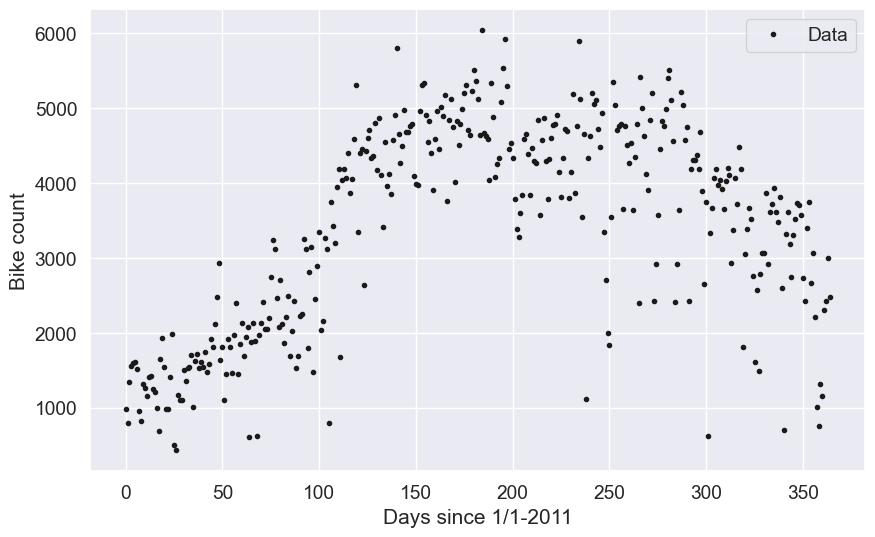

In [16]:
data = jnp.load('../data_exercise5b.npz')
day = data['day']
bike_count = data['bike_count']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(day, bike_count, 'k.', label='Data')
ax.legend()
ax.set(xlabel='Days since 1/1-2011', ylabel='Bike count');



print(len(bike_count))

**Task 5.1**: Log-transform the bike counts, remove the mean and scale to unit variance. Plot the preprocessed data set.



**Task 5.2**: Estimate the hyperparameters of a Gaussian process regression model with a squared exponential kernel from the preprocessed data. Report the estimated values of each hyperparameter.



In [18]:
# log-transform
# Input: bike_count (shape: (N,))
y = jnp.log(bike_count)
# Equation: y_i = log(bike_count_i)
print("Shape after log-transform:", y.shape)

# compute mean and standard deviation of log-counts
bmean, bstd = jnp.mean(y), jnp.std(y)
print("Mean (bmean):", bmean, "Std (bstd):", bstd)

# standardize log-counts
# Equation: y_std_i = (y_i - bmean) / bstd
standardize = lambda t_: (t_ - bmean) / bstd
y = standardize(y)
print("Shape after standardization:", y.shape)

# Input: day (shape: (N,))
X = day
print("Shape of X (day):", X.shape)

# Output:
# y: standardized log-bike counts, shape (N,)
# X: day, shape (N,)

Shape after log-transform: (365, 1)
Mean (bmean): 8.01900809186206 Std (bstd): 0.5278178614956573
Shape after standardization: (365, 1)
Shape of X (day): (365, 1)


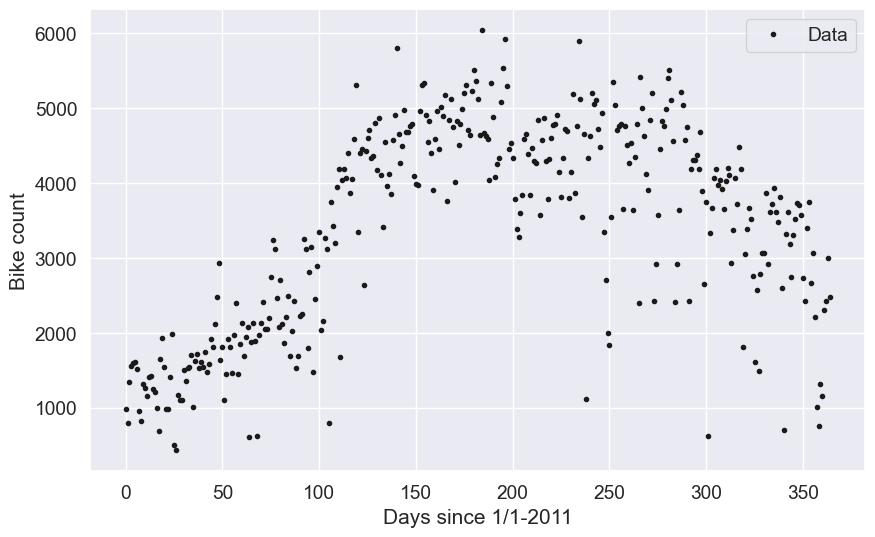

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(day, bike_count, 'k.', label='Data')
ax.legend()
ax.set(xlabel='Days since 1/1-2011', ylabel='Bike count');

In [19]:
# Prepare and fit a Gaussian Process regression model to the preprocessed bike data

# INPUTS:
#   X: (N, 1) array of days since 1/1-2011 (features)
#   y: (N, 1) array of standardized log-bike counts (targets)
# OUTPUTS:
#   kappa_hat: optimized kernel magnitude (scalar)
#   scale_hat: optimized kernel lengthscale (scalar)
#   sigma_hat: optimized noise std. dev. (scalar)
#   Prints estimated hyperparameters and log marginal likelihood

# 1. Instantiate GP regression model with squared exponential kernel
#    Model: y ~ GP(0, kappa^2 * exp(-0.5 * (x-x')^2 / scale^2)) + N(0, sigma^2)
gp = GaussianProcessRegression(X, y, StationaryIsotropicKernel(squared_exponential))

# 2. Optimize hyperparameters by maximizing the log marginal likelihood
#    Equation: θ_hat = argmax_θ log p(y | X, θ)
#    θ = [kappa, scale, sigma]
#    Input shape: theta_init (3,)
theta_hat = optimize_hyperparameters(gp, theta_init=jnp.array([1, 1, 50.]))

# 3. Extract optimized hyperparameters
#    Output shape: theta_hat (3,)
kappa_hat, scale_hat, sigma_hat = theta_hat

# 4. Set optimized hyperparameters in the GP model
gp.set_hyperparameters(kappa_hat, scale_hat, sigma_hat)

# 5. Print results
print('Estimated hyperparameters')
print(f'\tsigma: {sigma_hat:3.2f}')   # Noise std. dev.
print(f'\tkappa: {kappa_hat:3.2f}')   # Kernel magnitude
print(f'\tscale: {scale_hat:3.2f}')   # Kernel lengthscale
print('')
# Log marginal likelihood: log p(y | X, θ_hat)
print(f'Log Z: {gp.log_marginal_likelihood(kappa_hat, scale_hat, sigma_hat):3.2f}')


Estimated hyperparameters
	sigma: 0.57
	kappa: 1.08
	scale: 78.63

Log Z: -324.85


**Task 5.3**: Compute and visualize the predictive distribution for the interval $\text{day} \in \left\lbrace 0, 1, 2, \dots, 370 \right\rbrace$.

The shape of z's: (500, 10)
Shape of the mean, mu (500, 1)
Shape of mu after broadcasting (500, 1)
Shape of L: (500, 500)
Shape of f_samples (500, 10)
The shape of z's: (500, 10)
Shape of the mean, mu (500, 1)
Shape of mu after broadcasting (500, 1)
Shape of L: (500, 500)
Shape of f_samples (500, 10)


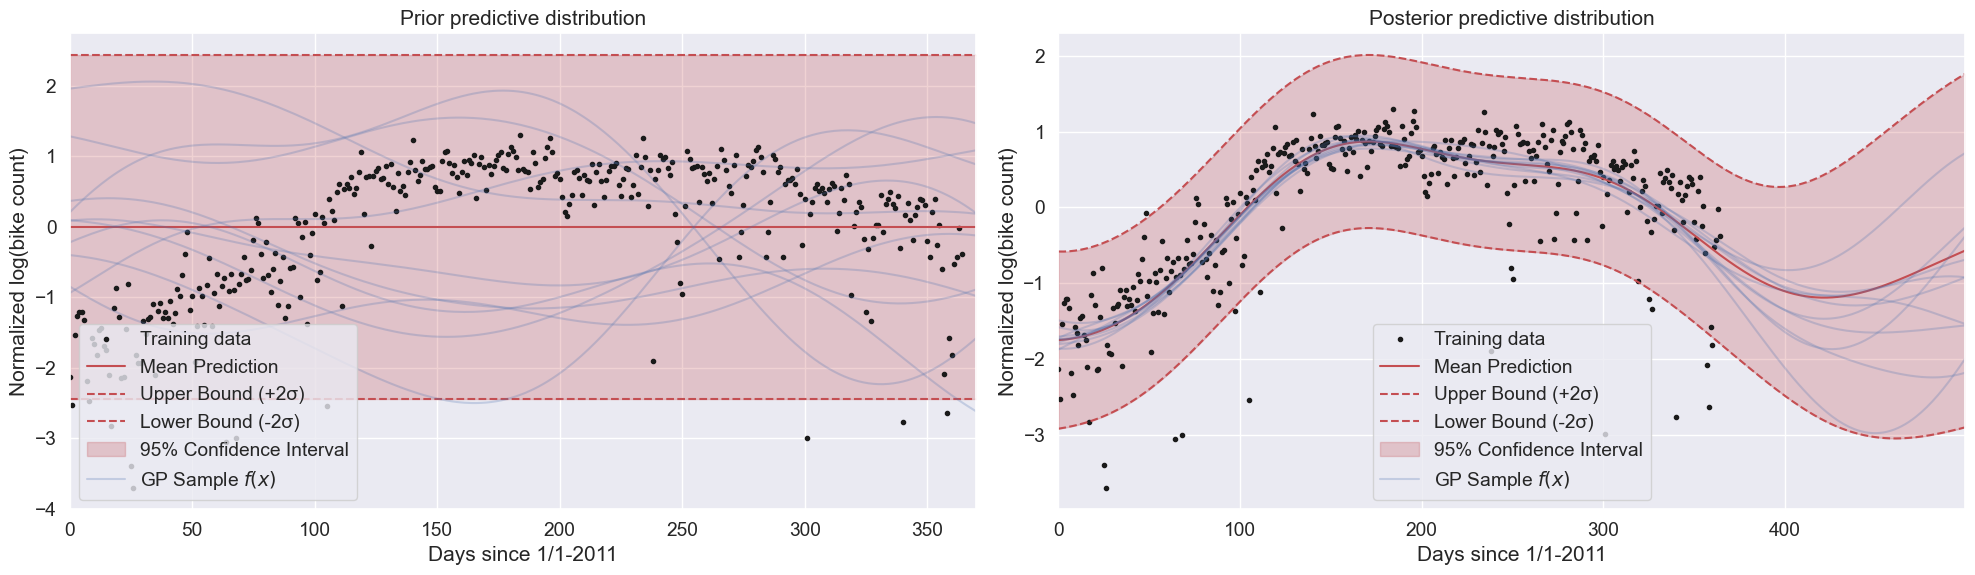

In [22]:
# Task 5.3: Compute and visualize the predictive distribution for days 0 to 370

# 1. Create a grid of days for prediction (input to GP)
#    Equation: days_pred = [[0], [1], ..., [370]]
#    Input shape: (N_pred, 1), where N_pred = 500 (for 0 to 499)
days_pred = jnp.arange(0, 500, 1).reshape(-1, 1)  # shape: (500, 1)

# 2. Create prior and posterior GP models with optimized hyperparameters
#    Inputs: kappa_hat, scale_hat, sigma_hat (scalars)
#    Output: gp_prior (prior GP), gp (posterior GP)
gp_prior = GaussianProcessRegression(
    jnp.zeros((0, 1)), jnp.zeros((0, 1)),
    StationaryIsotropicKernel(squared_exponential)
)
gp_prior.set_hyperparameters(kappa_hat, scale_hat, sigma_hat)

# 3. Compute posterior predictive mean and covariance for the prediction grid
#    Equation: mu_post, Sigma_post = gp.predict_f(days_pred)
#    Input: days_pred (500, 1)
#    Output: mu_post (500, 1), Sigma_post (500, 500)
mu_post, Sigma_post = gp.predict_f(days_pred)

# 4. Plot prior and posterior predictive distributions
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Left plot: Prior predictive distribution
#    Inputs: X (training days, shape (N, 1)), y (normalized log-counts, shape (N, 1))
#    Output: Scatter plot of training data, prior mean, confidence interval, and samples
ax[0].plot(X, y, 'k.', label='Training data')
plot_with_uncertainty(
    ax[0], days_pred, gp_prior,
    title='Prior predictive distribution', num_samples=10
)
ax[0].set_xlabel('Days since 1/1-2011')
ax[0].set_ylabel('Normalized log(bike count)')
ax[0].legend()
ax[0].set_xlim((0, 370))

# Right plot: Posterior predictive distribution
#    Inputs: X, y, gp (posterior GP), days_pred
#    Output: Scatter plot of training data, posterior mean, confidence interval, and samples
ax[1].plot(X, y, 'k.', label='Training data')
plot_with_uncertainty(
    ax[1], days_pred, gp,
    title='Posterior predictive distribution', num_samples=10
)
ax[1].set_xlabel('Days since 1/1-2011')
ax[1].set_ylabel('Normalized log(bike count)')
ax[1].legend()
ax[1].set_xlim((0, days_pred.max()))

plt.tight_layout()
plt.show()


**Task 5.4**: The observation model $p(y|f) = \mathcal{N}(y(x)|f(x), \sigma^2)$ assumes the additive noise is **isotropic** and **identically distributed** for all observations. Is that a reasonable assumption for this data set? **[Discussion question]**

**Task 5.5**: Generate 50 samples from the posterior in the interval [0, 370], map them back to the original measurement space and plot them on top of the original dataset

The shape of z's: (500, 100)
Shape of the mean, mu (500, 1)
Shape of mu after broadcasting (500, 1)
Shape of L: (500, 500)
Shape of f_samples (500, 100)


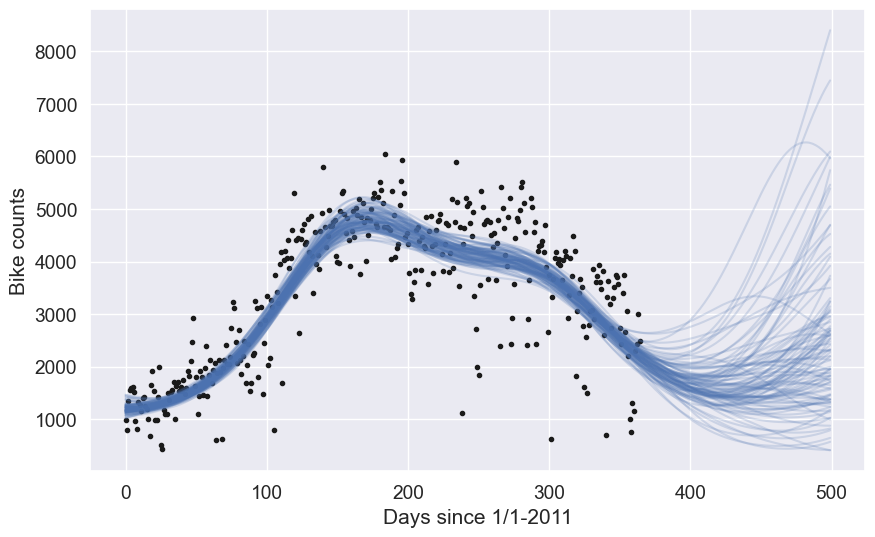

In [23]:
f_samples = gp.posterior_samples(key, days_pred, num_samples=100)

origina_space = f_samples * bstd + bmean


original_space_exp = jnp.exp(origina_space)


# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(X, bike_count, 'k.', label='Preprocessed data')
ax.plot(days_pred, original_space_exp, 'b', alpha=0.2);
ax.set(xlabel='Days since 1/1-2011', ylabel='Bike counts');


In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Using numpy for basic setup
import jax.numpy as jnp # GP requires jax numpy
import jax.random as random

# --- Step 1: Create a Dummy Gaussian Process Model ---
# In a real scenario, you would train a GP using a library like
# tinygp, GPJax, GPyTorch (with JAX backend), etc.
# Here we simulate a GP object with the required methods.
class MockGP:
    def __init__(self, noise_std=0.1):
        self.noise_std = noise_std

    def predict_y(self, Xp):
        # Simulate some mean function (e.g., sine wave)
        mu = jnp.sin(Xp.ravel()) 
        # Simulate some uncertainty (higher away from center)
        variance = 0.1 + 0.2 * (Xp.ravel()**2) + self.noise_std**2
        # Construct a plausible covariance matrix (diagonal for simplicity here)
        # A real GP would have off-diagonal elements reflecting correlations.
        Sigma = jnp.diag(variance)
        # Ensure mu has the right shape if needed (often (N,1))
        mu = mu.reshape(-1, 1)
        return mu, Sigma

    def posterior_samples(self, key, Xp, num_samples):
         # Get the predictive mean and covariance of the LATENT function f
         # (predict_y gives mean/cov of Y = f + noise)
         # For simplicity, let's approximate f's mean/cov from y's mean/cov
         mu_f, Sigma_f = self.predict_f(Xp)
         # Sample from a multivariate normal distribution
         # Need mean as (N,) and cov as (N, N) for JAX's mvn
         samples = random.multivariate_normal(key, mu_f.ravel(), Sigma_f, shape=(num_samples,))
         # Transpose samples to have shape (N, num_samples)
         return samples.T

    def predict_f(self, Xp):
         # Predict latent function (without observation noise)
         mu, Sigma_y = self.predict_y(Xp)
         # Subtract noise variance from diagonal of Sigma_y to get Sigma_f
         variance_f = jnp.diag(Sigma_y) - self.noise_std**2
         Sigma_f = jnp.diag(jnp.maximum(variance_f, 1e-6)) # Ensure positive variance
         return mu, Sigma_f

# --- Step 2: Define the plot_with_uncertainty Function ---
# (Paste the function provided in the question here)
def plot_with_uncertainty(ax, Xp, gp, color='r', color_samples='b', title="", num_samples=0, seed=0):
    """
    Plot the predictive mean and uncertainty (confidence interval) from a Gaussian Process (GP).

    This function visualizes the mean prediction, confidence intervals, and optionally samples from the GP posterior.

    Arguments:
        ax            -- Matplotlib axis where the plot will be drawn.
        Xp            -- Input points where the GP is evaluated (shape NxD, typically N,1).
        gp            -- Trained Gaussian Process model (must have predict_y and posterior_samples).
        color         -- Color for the mean and confidence interval (default: red).
        color_samples -- Color for the sampled functions (default: blue).
        title         -- Title of the plot (default: empty string).
        num_samples   -- Number of function samples to draw from the posterior (default: 0).
        seed          -- Random seed for reproducibility (default: 0).
    """
    # Predict the mean and covariance from the GP at the given test points Xp
    mu, Sigma = gp.predict_y(Xp)
    mean = mu.ravel()  # Flatten mean vector
    std = jnp.sqrt(jnp.diag(Sigma))  # Extract standard deviation from the diagonal of the covariance matrix

    # Generate a random seed for sampling
    key = random.PRNGKey(seed)

    # Plot the predictive mean
    ax.plot(Xp.ravel(), mean, color=color, lw=2, label='Mean Prediction') # Use Xp.ravel() for safety

    # Plot confidence interval (±2 standard deviations for ~95% confidence)
    ax.plot(Xp.ravel(), mean + 2*std, color=color, linestyle='--', label='95% CI Upper Bound') # Adjusted labels
    ax.plot(Xp.ravel(), mean - 2*std, color=color, linestyle='--', label='95% CI Lower Bound')
    ax.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.15, label='95% Confidence Interval') # Adjusted alpha/labels

    # Draw posterior samples if requested
    if num_samples > 0:
        fs = gp.posterior_samples(key, Xp, num_samples)  # Sample from the GP posterior
        # Plot samples
        ax.plot(Xp.ravel(), fs, color=color_samples, lw=0.5, alpha=0.5, label=f'{num_samples} GP Samples' if num_samples>0 else "") # Simplified plotting loop


    # Set the title of the plot
    ax.set_title(title)
    # Consolidate legend entries - Matplotlib might do this automatically depending on version/labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles)) # Remove duplicate labels
    ax.legend(by_label.values(), by_label.keys())
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Input X")
    ax.set_ylabel("Output Y")


# --- Step 3: Prepare Data and Plot ---

# Create some test points (where we want to predict)
X_pred = jnp.linspace(-5, 5, 100).reshape(-1, 1) # Shape (100, 1)

# Instantiate the mock GP
mock_gp_model = MockGP(noise_std=0.2)

# Create a plot figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Use the function to plot
plot_with_uncertainty(ax,
                      X_pred,
                      mock_gp_model,
                      color='darkblue',
                      color_samples='lightblue',
                      title="Gaussian Process Regression Visualization",
                      num_samples=10, # Draw 10 samples
                      seed=42)       # Use a seed for reproducibility

# Show the plot
plt.show()

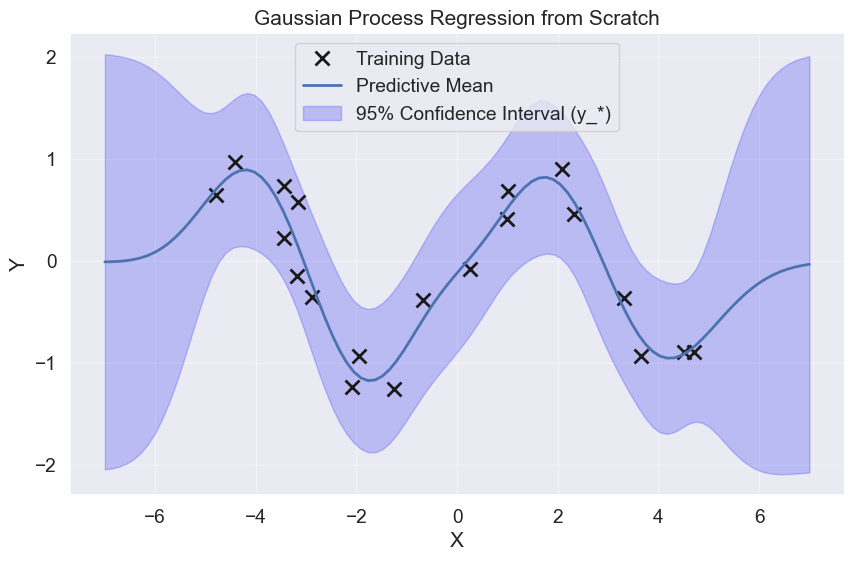

Log Marginal Likelihood: -13.73


In [ ]:
import numpy as np
from scipy.linalg import cho_solve, solve_triangular, cholesky
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Step 1: Define Kernel Function
def rbf_kernel(Xa, Xb, signal_variance, lengthscale):
    """ Radial Basis Function (RBF) kernel """
    # Use cdist for efficient pairwise distance calculation
    # ||Xa - Xb||^2
    sqdist = cdist(Xa / lengthscale, Xb / lengthscale, metric='sqeuclidean')
    # k(Xa, Xb) = signal_variance * exp(-0.5 * sqdist)
    return signal_variance * np.exp(-0.5 * sqdist)

# Step 2 & 3: Create GPR Class
class SimpleGPR:
    def __init__(self, signal_variance, lengthscale, noise_variance):
        self.signal_variance = signal_variance
        self.lengthscale = lengthscale
        self.noise_variance = noise_variance
        self.X_train = None
        self.y_train = None
        self.K_y = None
        self.L = None # Cholesky decomposition of K_y
        self.alpha = None # K_y^{-1} * y_train

    # Step 4: Fit Method
    def fit(self, X_train, y_train):
        """ Pre-compute quantities needed for prediction and likelihood """
        self.X_train = np.asarray(X_train)
        self.y_train = np.asarray(y_train)

        if self.X_train.ndim == 1:
            self.X_train = self.X_train[:, np.newaxis]
        if self.y_train.ndim == 1:
             self.y_train = self.y_train[:, np.newaxis] # Ensure y is (N, 1)

        N = self.X_train.shape[0]
        K = rbf_kernel(self.X_train, self.X_train, self.signal_variance, self.lengthscale)
        self.K_y = K + self.noise_variance * np.eye(N)

        try:
            # Compute Cholesky decomposition: K_y = L @ L.T
            self.L = cholesky(self.K_y, lower=True)
            # Compute alpha = K_y^{-1} @ y_train using Cholesky
            # Solve L @ v = y_train for v
            v = solve_triangular(self.L, self.y_train, lower=True, check_finite=False)
            # Solve L.T @ alpha = v for alpha
            self.alpha = solve_triangular(self.L.T, v, lower=False, check_finite=False)
            self._fit_succeeded = True
        except np.linalg.LinAlgError:
            print("Warning: Cholesky decomposition failed. Matrix may be ill-conditioned.")
            # Fallback or raise error - here just marking as failed
            self._fit_succeeded = False
            self.L = None
            self.alpha = None


    # Step 5: Predict Method (predicts latent function f_*)
    def predict_f(self, X_test):
        """ Predict mean and covariance of the latent function f_* """
        if not self._fit_succeeded:
             raise RuntimeError("GPR model has not been successfully fitted.")

        if X_test.ndim == 1:
            X_test = X_test[:, np.newaxis]

        # Calculate cross-covariance K_* and test covariance K_**
        K_star = rbf_kernel(X_test, self.X_train, self.signal_variance, self.lengthscale)
        K_star_star = rbf_kernel(X_test, X_test, self.signal_variance, self.lengthscale)

        # Predictive mean: f_mean = K_* @ alpha
        f_mean = K_star @ self.alpha

        # Predictive covariance: cov(f_*) = K_** - K_* @ K_y^{-1} @ K_*^T
        # Use Cholesky: Solve L @ V = K_*^T for V, then cov = K_** - V^T @ V
        V = solve_triangular(self.L, K_star.T, lower=True, check_finite=False)
        f_cov = K_star_star - V.T @ V

        return f_mean, f_cov

    # Helper to predict noisy observations y_*
    def predict_y(self, X_test):
        """ Predict mean and covariance of noisy observations y_* """
        f_mean, f_cov = self.predict_f(X_test)
        # Mean is the same
        y_mean = f_mean
        # Covariance adds noise variance to the diagonal
        y_cov = f_cov + self.noise_variance * np.eye(f_cov.shape[0])
        return y_mean, y_cov


    # Step 6: Marginal Log-Likelihood
    def log_marginal_likelihood(self):
        """ Calculate the log marginal likelihood of the training data """
        if not self._fit_succeeded:
             # Return a very small number if fit failed
             return -np.inf

        # log p(y|X) = -0.5 * y^T @ alpha - sum(log(diag(L))) - 0.5 * N * log(2*pi)
        log_likelihood = -0.5 * self.y_train.T @ self.alpha
        log_likelihood -= np.sum(np.log(np.diag(self.L)))
        log_likelihood -= 0.5 * self.X_train.shape[0] * np.log(2 * np.pi)

        return log_likelihood.item() # Return scalar

# --- Example Usage ---

# 1. Generate some sample data
np.random.seed(42)
N_train = 20
X_train = np.random.uniform(-5, 5, N_train)
# True function (e.g., sin wave) + noise
y_train = np.sin(X_train) + np.random.normal(0, 0.3, N_train)
X_test = np.linspace(-7, 7, 100)

# 2. Instantiate and Fit the GPR
# (These hyperparameters could be optimized using log_marginal_likelihood)
gp = SimpleGPR(signal_variance=1.0, lengthscale=1.0, noise_variance=0.3**2)
gp.fit(X_train, y_train)

# 3. Make Predictions (predicting y_*, including noise uncertainty)
y_mean, y_cov = gp.predict_y(X_test)
y_std = np.sqrt(np.diag(y_cov)) # Extract standard deviation

# 4. Plot Results (Adapting the previous plot function concept)
plt.figure(figsize=(10, 6))
# Plot training data
plt.plot(X_train, y_train, 'kx', markersize=10, mew=2, label='Training Data')
# Plot predictive mean
plt.plot(X_test, y_mean, 'b-', lw=2, label='Predictive Mean')
# Plot confidence interval (95% CI -> approx 1.96 * std dev)
plt.fill_between(X_test,
                 y_mean.ravel() - 1.96 * y_std,
                 y_mean.ravel() + 1.96 * y_std,
                 color='blue', alpha=0.2, label='95% Confidence Interval (y_*)')

plt.title('Gaussian Process Regression from Scratch')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

# Optional: Print log-likelihood for these hyperparameters
print(f"Log Marginal Likelihood: {gp.log_marginal_likelihood():.2f}")

# --- Optional: Hyperparameter Optimization ---
# You would typically wrap the GPR initialization and log-likelihood calculation
# in an objective function and use scipy.optimize.minimize.
# Note: Optimization requires careful handling of parameter bounds (variances > 0, lengthscale > 0)
# and gradients for efficiency.

# from scipy.optimize import minimize

# def negative_log_likelihood(params, X, y):
#     signal_var, lengthscale, noise_var = np.exp(params) # Use exp to ensure positivity
#     gp_opt = SimpleGPR(signal_var, lengthscale, noise_var)
#     gp_opt.fit(X, y)
#     log_lik = gp_opt.log_marginal_likelihood()
#     # Add penalty if fit failed
#     if not gp_opt._fit_succeeded:
#         return np.inf
#     return -log_lik

# initial_params = np.log([1.0, 1.0, 0.1]) # Initial guess in log space
# result = minimize(negative_log_likelihood, initial_params, args=(X_train, y_train), method='L-BFGS-B')

# if result.success:
#     optimized_params_log = result.x
#     optimized_params = np.exp(optimized_params_log)
#     print(f"Optimized Params (sigma_f^2, l, sigma_n^2): {optimized_params}")

#     # Re-fit and plot with optimized params
#     gp_optimized = SimpleGPR(*optimized_params)
#     # ... (fit, predict, plot again) ...
# else:
#     print("Optimization failed:", result.message)